# Errors in prediction of Dst from L5/STEREO-B

This script evaluates the errors in the prediction of Dst from solar wind measurements taken at a point behind in Earth's orbit that experiences the rotation in solar wind streams earlier.

Operations:
1. DATA READING - Reads in STEREO-B and OMNI data.
2. DATA CORRECTIONS - Applies time shift and wind expansion corrections to STEREO-B data.
3. DATA ANALYSIS - Longitudinal dependence, latitudinal dependence, event-based analysis.

In [1]:
# Conda dependencies are listed under environment.yml
import os
import sys
import copy
from datetime import datetime, timedelta
import getpass
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import num2date, date2num
import numpy as np
import pdb
import pickle
import requests
import scipy.io
from scipy import stats
import scipy
import warnings

import seaborn as sns
from sklearn.metrics import mean_squared_error

import heliosat
import predstorm as ps
from predstorm.config.constants import AU, dist_to_L1
from predstorm.predict import dst_loss_function

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

In [2]:
# Function for printing statistics on dst diffs
def get_statistics(dst_pred, dst_real, source='L1', printtext=True):
    """Prints some nice statistics, that's all.
    
    Parameters
    ----------
    dst_pred : np.ndarray
        Array containing predicted Dst values.
    dst_real : np.ndarray
        Array containing real Dst values. Same length as dst_pred.
    source : str (opt, default='L1')
        String to denote source for comparison string prints.
    printtext : bool (opt, default=True)
        If True, prints string summarising stats.
        
    Returns
    -------
    stat_dict : dict
        Dictionary containing values under the keys ['diff_mean', 'diff_std',
        'xcorr', 'ppmc', 'mae', 'rmse']"""

    dst_diff = dst_real - dst_pred
    dst_diff_mean = np.sum(dst_diff) / len(dst_diff)
    dst_diff_std = np.sqrt(np.sum(dst_diff*dst_diff) / len(dst_diff))
    t = np.linspace(0.0, stbh['time'][-1] - stbh['time'][0], len(dst_real), endpoint=False)
    dt = np.linspace(-t[-1], t[-1], 2*len(dst_real)-1)
    xcorr = scipy.signal.correlate(dst_real, dst_pred)
    ppmc = np.corrcoef(dst_real, dst_pred)[0][1]
    mae = np.sum(np.abs(dst_diff)) / len(dst_diff)
    rmse = np.sqrt(mean_squared_error(dst_real, dst_pred))
    if printtext:
        print("DATA FROM {}".format(source))
        print("----------"+'-'*len(source))
        print('Dst diff mean +/- std: {:.2f} +/- {:.2f}'.format(dst_diff_mean, dst_diff_std))
        print("")
        print('Dst obs  mean +/- std: {:.2f} +/- {:.2f}'.format(np.nanmean(dst_real), np.nanstd(dst_real)))
        print('Dst pred mean +/- std: {:.2f} +/- {:.2f}'.format(np.nanmean(dst_pred), np.nanstd(dst_pred)))
        print('Dst obs  min / max: {:.2f} / {:.2f}'.format(np.nanmin(dst_real), np.nanmax(dst_real)))
        print('Dst pred min / max: {:.2f} / {:.2f}'.format(np.nanmin(dst_pred), np.nanmax(dst_pred)))
        print()
        print("Pearson correlation: {:.2f} ".format(ppmc))
        print("Cross-correlation:   {:.1f} hours".format(24.*dt[xcorr.argmax()]))
        print("Mean absolute error: {:.2f} nT".format(mae))
        print("RMSE:                {:.2f} nT".format(rmse))
        print()

    stat_dict = {}
    stat_dict['diff_mean'] = dst_diff_mean
    stat_dict['diff_std'] = dst_diff_std
    stat_dict['xcorr'] = 24.*dt[xcorr.argmax()]
    stat_dict['ppmc'] = ppmc
    stat_dict['mae'] = mae
    stat_dict['rmse'] = rmse

    return stat_dict

In [3]:
# STARTING PARAMETERS
# -------------------
# Choose which data set to use: BEACON (real-time) or L2 (science level)
use_stereo_beacon = True   # if False, L1/L2 data will be used
# Angles between Earth and STB (in deg) to look at
angle_bracket = [-0, -110] # from 1 till 2 in time (can't be backwards)
# Calculating the mean over this window
mean_range = int(4/2)    # hours
# Time (days) assumed for solar wind persistence
t_pers = 27.27           # days
# Defining events:
event_window = int(24/2) # hours
event_threshold = -35    # nT
# Plotting parameters
nfig = 1
sns.set(style="whitegrid")
figwidth = 12
figheight = 5
figsize_half = (figwidth/2, figheight)
varcolors = {'speed': 'teal', 'btot': 'orange', 'bx': 'green', 'by': 'brown', 'bz': 'purple'}
modc = {'omni': 'r', 'stb': 'b', 'pers': 'grey'}
modnames = modc.keys()
alpha_pers = 0.7

## DATA READING

1. Reading in STEREO-B data. SatData objects is stored as pickles to speed up reading time.
2. Read OMNI2 data set.
3. Create persistence model (with 27-day recurrence) from OMNI data.

In [4]:
# --------------------------------------------------------------------------
# **************************************************************************
#
# IF LOADING DATA OBJECTS FROM PICKLE FILES, SKIP ALL BELOW
#
# **************************************************************************
# --------------------------------------------------------------------------
# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

# Load STEREO-B data
if use_stereo_beacon:
    pickle_path = 'data/stb_satdata_beacon_h.p'
    if os.path.exists(pickle_path):
        stb = pickle.load(open(pickle_path, 'rb'))
        stb.h['HeliosatObject'] = heliosat.STB()
        stb.h['RemovedTimes'] = []
    else:
        # WARNING: Run this the very first time and it will download entire STEREO-B beacon data set
        # Note: May need to update PREDSTORM: github.com/helioforecast/Predstorm
        print("Creating pickled file of 1h STEREO-B BEACON data...")
        starttime = datetime(2007,3,20)
        endtime = datetime(2012,5,1)
        stb = ps.get_stereo_beacon_data(starttime, endtime, resolution='hour', which_stereo='behind')
        with open(pickle_path, 'wb') as pickle_file:
            pickle.dump(stb, pickle_file)
else:
    pickle_path = 'data/stb_satdata_l2_h.p'
    if os.path.exists(pickle_path):
        stb = pickle.load(open(pickle_path, 'rb'))
        stb.h['HeliosatObject'] = heliosat.STB()
    else:
        # WARNING: This code automatically downloads and resamples all yearly STEREO-B L2 data
        # from 1min to 1hour resolution.
        from spacepy import pycdf
        from predstorm import SatData
        varnames = ['Epoch', 'Vp', 'Vr_Over_V_RTN', 'Np', 'Tp', 'BFIELDRTN']
        alldata = {k: [] for k in varnames}
        if not os.path.exists('stbdata'):
            os.mkdir('stbdata')
        for year in ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']:
            cdf_write = 'stbdata/STB_L2_MAGPLASMA_1m_{}_V01.cdf'.format(year)
            if not os.path.exists(cdf_write):
                cdf_url = ("https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level2/behind/magplasma/STB_L2_MAGPLASMA_1m_{}_V01.cdf".format(year))
                cdf_file = requests.get(url)
                open(cdf_write, 'wb').write(cdf_file.content)
            cdf = pycdf.CDF(cdf_write)
            for var in varnames:
                data = cdf[var][...]
                fillval = cdf[var].attrs['FILLVAL']
                data[np.where(data < cdf[var].attrs['VALIDMIN'])] = np.NaN
                data[np.where(data > cdf[var].attrs['VALIDMAX'])] = np.NaN
                alldata[var].append(data)

        arrays = {}
        for var in varnames:
            arrays[var] = np.concatenate(alldata[var])

        STEREO_ = heliosat.STB()

        tarray = [date2num(x) for x in arrays['Epoch']]
        bfieldtotal = np.sqrt(arrays['BFIELDRTN'][:,0]**2. + arrays['BFIELDRTN'][:,1]**2. + 
                              arrays['BFIELDRTN'][:,2]**2.)
        stb = SatData({'time': tarray,
                       'btot': bfieldtotal, 'br': arrays['BFIELDRTN'][:,0], 
                       'bt': arrays['BFIELDRTN'][:,1], 'bn': arrays['BFIELDRTN'][:,2],
                       'speed': arrays['Vp'], 'speedx': arrays['Vp'], 'density': arrays['Np'], 
                       'temp': arrays['Tp']}, source='STEREO-B')
        stb.h['DataSource'] = "STEREO-B L2"
        stb.h['SamplingRate'] = tarray[1] - tarray[0]
        stb.h['ReferenceFrame'] = STEREO_.spacecraft['data_keys']['stb_impact_l1']['version_default']['columns'][0]['frame']
        stb.h['HeliosatObject'] = STEREO_
        stb.h['Instruments'] = ['PLASTIC', 'IMPACT']

        stb = stb.make_hourly_data()
        with open(pickle_path, 'wb') as f:
            pickle.dump(stb, f)

# Converting RTN to quasi-GSE (just swap x- and y-directions):
stb['bx'], stb['by'], stb['bz'] = -stb['br'], -stb['bt'], stb['bn']
stb = stb.interp_nans()
# Converting quasi-GSE to quasi-GSM:
stb.convert_GSE_to_GSM()
print(stb)

Length of data:		65328
Keys in data:		['speed', 'speedx', 'density', 'temp', 'btot', 'br', 'bt', 'bn', 'bx', 'by', 'bz']
First data point:	2007-03-20 00:00:00+00:00
Last data point:	2014-08-31 23:00:00+00:00

Header information:
                   DataSource:	STEREO-B Beacon
                    SourceURL:	
                 SamplingRate:	0.04166666662786156
             CoordinateSystem:	SCEQ
                  FileVersion:	{}
                  Instruments:	[]
               HeliosatObject:	<heliosat.satellites.STB object at 0x10d221c18>
                 RemovedTimes:	[]
               ReferenceFrame:	GSM

Variable statistics:
         VAR        MEAN         STD
       speed      400.08       99.78
      speedx      395.97       95.51
     density        4.21        3.62
        temp    81392.35    84237.98
        btot        4.60        2.95
          br       -0.15        2.98
          bt        0.17        3.51
          bn        0.02        2.85
          bx        0.15        2.

In [5]:
# Load OMNI data
omni_path = 'data/omni2_all_years.dat'
if os.path.exists(omni_path):
    omni = ps.get_omni_data(filepath=omni_path)
else:
    omni = ps.get_omni_data(download=True)
omni = omni.interp_nans()
print(omni)

Length of data:		508440
Keys in data:		['speed', 'speedx', 'density', 'temp', 'pdyn', 'bx', 'by', 'bz', 'btot', 'dst', 'kp', 'ae']
First data point:	1963-01-01 00:00:00+00:00
Last data point:	2020-12-31 23:00:00+00:00

Header information:
                   DataSource:	OMNI (NASA OMNI2 data)
                    SourceURL:	
                 SamplingRate:	0.04166666662786156
               ReferenceFrame:	GSM
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10
               HeliosatObject:	<heliosat.spice.SpiceObject object at 0x1c1fd62be0>

Variable statistics:
         VAR        MEAN         STD
       speed      436.30      101.21
      speedx     -430.52       96.35
     density        7.12        5.32
        temp   106375.37   100541.32
        pdyn        2.42        1.87
          bx       -0.07        3.64
          by        0.03        3.91
          bz        0.01        3.03
        btot   

In [6]:
# Load position data
stb.load_positions()

In [7]:
# Copy data for 27-day 'persistence' or recurrence model
pers = copy.deepcopy(omni)
pers['time'] += t_pers # add 27 days
pers = pers.interp_to_time(omni['time'])

## DATA CORRECTION

1. Cut time series to STEREO-B data within angle bracket evaluated. 
2. Shift STEREO-B wind variables (magn. field variables, density) to smaller Earth orbit.
3. Calculate Temerin-Li Dst prediction for each set of input solar wind variables. (Important to do this before CME removal so that we get the full Dst development without missing time windows.)
4. Shift time in STEREO-B data to expected arrival times at L1.
5. Remove ICMEs. Need to be careful to match original STEREO-B ICME timings to final shifted time to remove properly from the final shifted arrays.
6. Do final time cut so that time ranges and points match up exactly through interpolating onto same time array.
7. Save corrected data as pickled objects for easy and quick loading later.
8. Plot some data as sanity check.

In [8]:
# Extract intervals from STEREO-B data
min_time = np.round(stb['time'][np.where(stb.pos['lon']*180/np.pi < angle_bracket[0])[0][0]], 0)
min_time = date2num(datetime(2007,2,18))
#min_time -= 30. # add +/- 60 days for buffer in data correction before actual cut
max_time = np.round(stb['time'][np.where(stb.pos['lon']*180/np.pi < angle_bracket[1])[0][0]], 0)
max_time += 30.
print('Time range covered for analysis in angle bracket {}:'.format(angle_bracket))
print('start:', num2date(min_time))
print('end:  ', num2date(max_time))

# Cut data to within time range STEREO-B is inside angles (+/- 1 month)
stbh = stb.make_hourly_data()
stbh = stbh.cut(starttime=num2date(min_time), endtime=num2date(max_time))
omni = omni.cut(starttime=num2date(min_time), endtime=num2date(max_time))
pers = pers.cut(starttime=num2date(min_time), endtime=num2date(max_time))

Time range covered for analysis in angle bracket [0, -110]:
start: 2007-02-18 00:00:00+00:00
end:   2012-01-25 00:00:00+00:00


In [9]:
# Shift wind from L5 to L1 to account for orbital distance and areal expansion:
# NOTE: To check influence of this scaling, just uncomment this line and compare results
stbh = stbh.shift_wind_to_L1()

In [10]:
# Get positions of STEREO-B
stbh_pos = copy.deepcopy(stbh)
stbh.load_positions()
# These will be the 'fake' lat/lon values mapped to the shifted time to match up to shifted plasma data
stbh_lats = stbh_pos.pos['lat']
stbh_lons = stbh_pos.pos['lon']

In [11]:
# Shift time from L5 to L1
t_unmapped = copy.deepcopy(stbh['time'])
stbh = stbh.shift_time_to_L1(method='new', sun_syn=t_pers)
# Keep unmapped/mapped time arrays to know which actual time maps to which shifted time
t_mapped = copy.deepcopy(stbh['time'])
if use_stereo_beacon:
    stbh = stbh.make_hourly_data()
else: # time ranges don't match for L2 data, this makes it easier:
    stbh = stbh.interp_to_time(omni['time'])
    pers = pers.interp_to_time(omni['time'])
stbh.load_positions()

In [12]:
# Calculate model Dst
stbh['dst'] = stbh.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
# (Use 'ae' to not overwrite OMNI Kyoto Dst values)
omni['ae'] = omni.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
pers['dst'] = pers.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
# Apply correction using formerly-trained GradientBoostingRegressor (sklearn) model:
# (This model provides a correction to the original Temerin-Li output as an enhancement.)
with open('dst_pred_model_final.pickle', 'rb') as f:
    model = pickle.load(f)
dstdiff_pred = stbh.make_dst_prediction_from_model(model)['dst']
dstdiff_pred_omni = omni.make_dst_prediction_from_model(model)['dst']
dstdiff_pred_pers = pers.make_dst_prediction_from_model(model)['dst']
stbh['dst'] += dstdiff_pred
omni['ae'] += dstdiff_pred_omni
pers['dst'] += dstdiff_pred_pers

### Remove ICMEs

Well, just set time ranges of ICME passings as NaNs to remove later.

Leave out next few steps if you want to keep ICMEs.

In [13]:
# Download ICME data to remove from data
icmes_stb = ps.get_icme_catalogue("data/HELCATS_ICMECAT_v10_SCEQ.txt", 'STEREO-B', 
                                  starttime=num2date(min_time), endtime=num2date(max_time))
icmes_omni = ps.get_icme_catalogue("data/HELCATS_ICMECAT_v10_SCEQ.txt", 'Wind', 
                                   starttime=num2date(min_time), endtime=num2date(max_time))
print("STB ICMEs: {}\nL1 ICMEs: {}".format(len(icmes_stb), len(icmes_omni)))

STB ICMEs: 72
L1 ICMEs: 73


In [14]:
# Map STEREO-B CME times to new, shifted times
mapped_stb_times = []
for icme in icmes_stb:
    # Map ICME start time to new STB time mapping:
    icme_start = icme['ICME_START_TIME']
    ts0_stb = t_unmapped[(np.abs(t_unmapped-icme_start)).argmin()]     # value in unmapped array
    ts1_stb = t_mapped[(np.abs(t_unmapped-icme_start)).argmin()]       # value in mapped array
    ts1_stb_h = stbh['time'][(np.abs(stbh['time']-ts1_stb)).argmin()]  # mapped value in new hourly array
    # Map ICME end time to new STB time mapping:
    icme_end = icme['MO_END_TIME']
    te0_stb = t_unmapped[(np.abs(t_unmapped-icme_end)).argmin()]
    te1_stb = t_mapped[(np.abs(t_unmapped-icme_end)).argmin()]
    te1_stb_h = stbh['time'][(np.abs(stbh['time']-te1_stb)).argmin()]
    # Save both to array:
    mapped_stb_times.append({'start': ts1_stb_h, 'end': te1_stb_h})
    # Verification of method:
    #print(num2date(icme_start), num2date(ts1_stb_h), num2date(te1_stb_h), 
    #      "{:.1f} --> {:.1f} hours".format((icme['MO_END_TIME']-icme['ICME_START_TIME'])*24.,
    #                                     (te1_stb_h-ts1_stb_h)*24.))

In [15]:
# Remove OMNI/L1 ICMEs:
for icme in icmes_omni:
    icme_inds = np.where(np.logical_and(omni['time'] > icme['ICME_START_TIME'], 
                                        omni['time'] < icme['ICME_END_TIME']))
    omni.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(stbh['time'] > icme['ICME_START_TIME'], 
                                        stbh['time'] < icme['ICME_END_TIME']))
    stbh.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(pers['time'] > icme['ICME_START_TIME'], 
                                        pers['time'] < icme['ICME_END_TIME']))
    pers.data[1:,icme_inds] = np.nan
# Remove STEREO-B ICMEs:
for icme in mapped_stb_times:
    icme_inds = np.where(np.logical_and(omni['time'] > icme['start'], omni['time'] < icme['end']))
    omni.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(stbh['time'] > icme['start'], stbh['time'] < icme['end']))
    stbh.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(pers['time'] > icme['start'], pers['time'] < icme['end']))
    pers.data[1:,icme_inds] = np.nan
# Remove PERS MODEL ICMEs:
for icme in icmes_omni:
    icme_inds = np.where(np.logical_and(omni['time'] > icme['ICME_START_TIME']+t_pers, 
                                        omni['time'] < icme['ICME_END_TIME']+t_pers))
    omni.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(stbh['time'] > icme['ICME_START_TIME']+t_pers, 
                                        stbh['time'] < icme['ICME_END_TIME']+t_pers))
    stbh.data[1:,icme_inds] = np.nan
    icme_inds = np.where(np.logical_and(pers['time'] > icme['ICME_START_TIME']+t_pers, 
                                        pers['time'] < icme['ICME_END_TIME']+t_pers))
    pers.data[1:,icme_inds] = np.nan

### Cut data to time range

Data is prepared, so cut to final time range, save results for statistical comparison and continue with data analysis.

In [16]:
# Final cut
stime_new = num2date(max((omni['time'][0], stbh['time'][0], pers['time'][0])))
etime_new = num2date(min((omni['time'][-1], stbh['time'][-1], pers['time'][-1])))
print()

print('Time range correction after time shift:')
print('start:', stime_new)
print('end:  ', etime_new)

stbh = stbh.cut(starttime=stime_new, endtime=etime_new)
omni = omni.cut(starttime=stime_new, endtime=etime_new)
pers = pers.cut(starttime=stime_new, endtime=etime_new)
print("After cut:", len(omni), len(stbh), len(pers))


Time range correction after time shift:
start: 2007-03-19 22:00:00+00:00
end:   2012-01-24 23:00:00+00:00
After cut: 42529 42529 42529


### Save / load pickled objects

Reading takes a while, so pickle the processed files for reading on the next run.

In [17]:
pickle_path_s = 'data/stb_satdata_h_proc.p'
with open(pickle_path_s, 'wb') as pickle_file_s:
    pickle.dump(stbh, pickle_file_s)
pickle_path_o = 'data/omni_satdata_h_proc.p'
with open(pickle_path_o, 'wb') as pickle_file_o:
    pickle.dump(omni, pickle_file_o)
pickle_path_p = 'data/pers_satdata_h_proc.p'
with open(pickle_path_p, 'wb') as pickle_file_p:
    pickle.dump(pers, pickle_file_p)
pickle_path_m = 'data/mapping_arrays.p'
mapping_arrays = [t_unmapped, t_mapped, stbh_lats, stbh_lons]
with open(pickle_path_m, 'wb') as pickle_file_m:
    pickle.dump(mapping_arrays, pickle_file_m)

In [18]:
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# --------------------------------------------------------------------------
# **************************************************************************
#
# IF LOADING DATA OBJECTS FROM PICKLE FILES, SKIP ALL ABOVE
#
# **************************************************************************
# --------------------------------------------------------------------------

pickle_path_s = 'data/stb_satdata_h_proc.p'
pickle_path_o = 'data/omni_satdata_h_proc.p'
pickle_path_p = 'data/pers_satdata_h_proc.p'
pickle_path_m = 'data/mapping_arrays.p'
stbh = pickle.load(open(pickle_path_s, 'rb'))
omni = pickle.load(open(pickle_path_o, 'rb'))
pers = pickle.load(open(pickle_path_p, 'rb'))
[t_unmapped, t_mapped, stbh_lats, stbh_lons] = pickle.load(open(pickle_path_m, 'rb'))

In [19]:
omni_mean, omni_std = copy.deepcopy(omni), copy.deepcopy(omni)
stbh_mean, stbh_std = copy.deepcopy(stbh), copy.deepcopy(stbh)
pers_mean, pers_std = copy.deepcopy(pers), copy.deepcopy(pers)
for sw_var in ['speed', 'btot', 'bx', 'by', 'bz']:
    for i in range(mean_range, len(stbh)-mean_range):
        omni_mean[sw_var][i] = np.nanmean(omni[sw_var][i-mean_range:i+mean_range])
        omni_std[sw_var][i] = np.nanstd(omni[sw_var][i-mean_range:i+mean_range])
        stbh_mean[sw_var][i] = np.nanmean(stbh[sw_var][i-mean_range:i+mean_range])
        stbh_std[sw_var][i] = np.nanstd(stbh[sw_var][i-mean_range:i+mean_range])
        pers_mean[sw_var][i] = np.nanmean(pers[sw_var][i-mean_range:i+mean_range])
        pers_std[sw_var][i] = np.nanstd(pers[sw_var][i-mean_range:i+mean_range])

### Make plot of data set

That's it.

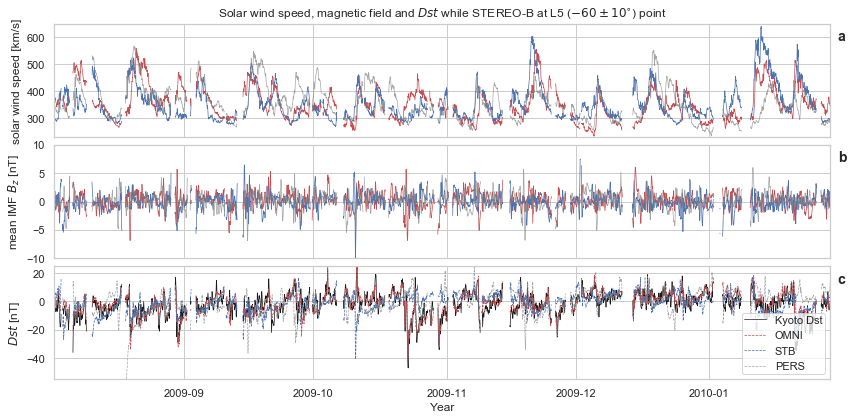

In [20]:
nfig += 1
main_lw = 0.7
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, num=nfig, figsize=(figwidth,6), sharex=True)
ax1.plot_date(omni['time'], omni['speed'], '-', c=modc['omni'], lw=main_lw, label="OMNI")
ax1.plot_date(stbh['time'], stbh['speed'], '-', c=modc['stb'], lw=main_lw, label="STB")
ax1.plot_date(pers['time'], pers['speed'], '-', c=modc['pers'], alpha=alpha_pers, lw=main_lw, label="PERS")
#ax2.plot_date(omni['time'], omni['bz'], '-', c=modc['omni'], lw=0.3, alpha=0.3)
ax2.plot_date(omni['time'], omni_mean['bz'], '-', c=modc['omni'], lw=main_lw, label="OMNI")
#ax2.plot_date(stbh['time'], stbh['bz'], '-', c=modc['stb'], lw=0.3, alpha=0.3)
ax2.plot_date(stbh['time'], stbh_mean['bz'], '-', c=modc['stb'], lw=main_lw, label="STB")
ax2.plot_date(pers['time'], pers_mean['bz'], '-', c=modc['pers'], alpha=alpha_pers, lw=main_lw, label="PERS")
ax3.plot_date(omni['time'], omni['dst'], 'k-', lw=main_lw, label='Kyoto Dst')
ax3.plot_date(omni['time'], omni['ae'], '--', c=modc['omni'], lw=main_lw, label='OMNI')
ax3.plot_date(stbh['time'], stbh['dst'], '--', c=modc['stb'], lw=main_lw, label='STB')
ax3.plot_date(pers['time'], pers['dst'], '--', c=modc['pers'], alpha=alpha_pers, lw=main_lw, label='PERS')
ax1.set_title('Solar wind speed, magnetic field and $Dst$ while STEREO-B at L5 ($-60 \pm 10^{\circ}$) point')

angle_bracket_reduced = [-50, -70]
min_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < angle_bracket_reduced[0])[0][0]], 0)
max_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < angle_bracket_reduced[1])[0][0]], 0)
ax1.set_xlim((min_time, max_time))
ax1.set_ylim((230,650))
#ax1.legend(loc="upper left", borderpad=0.2)
ax1.set_ylabel("solar wind speed [km/s]")
ax2.set_xlim((min_time, max_time))
ax2.set_ylim((-10, 10))
ax2.set_ylabel("mean IMF $B_{z}$ [nT]")
ax3.set_xlim((min_time, max_time))
ax3.set_ylim((-55,25))
ax3.set_xlabel('Year')
ax3.set_ylabel("$Dst$ [nT]")
ax3.legend(loc="lower right", borderpad=0.2)
for ax, ann in zip([ax1, ax2, ax3], ['a', 'b', 'c']):
    ax.text(1.01, 0.85, ann, transform=ax.transAxes, fontsize=14, weight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.07)
plt.savefig("plots/example_data.pdf")
plt.show()

### Make plot of density curves of Dst

That's also it.

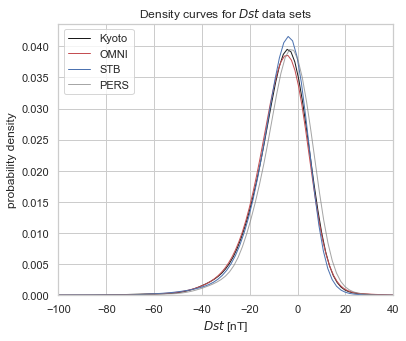

In [21]:
bw = 4
lw = 1
fig = plt.figure(figsize=figsize_half)
ax1 = sns.kdeplot(omni['ae'], bw=bw, color='k', lw=lw, label="Kyoto")
ax1 = sns.kdeplot(omni['dst'], bw=bw, color=modc['omni'], lw=lw, label="OMNI")
ax1 = sns.kdeplot(stbh['dst'], bw=bw, color=modc['stb'], lw=lw, label="STB")
ax1 = sns.kdeplot(pers['dst'], bw=bw, color=modc['pers'], alpha=alpha_pers, lw=lw, label="PERS")
plt.legend(loc="upper left")
plt.title("Density curves for $Dst$ data sets")
plt.xlim((-100,40))
plt.xlabel("$Dst$ [nT]")
plt.ylabel("probability density")
plt.savefig("plots/density_curve.pdf")
plt.show()

## DATA ANALYSIS (FULL RANGE)

Some basic data preparation, and then...

1. Correlation of variables speed/magn. field as STEREO-B moves away from the Earth
2. Dst accuracy depending on L5-L1 longitude angle diff
3. Analysis of values according to Carrington rotation
4. Dst accuracy depending on L5-L1 latitude diff
5. Event-based analysis with 12-hour windows

In [22]:
# Remove all nans (= ICMEs)
print("With all data:     ", len(omni), len(stbh), len(pers))
before_icmes = len(omni)
# Get new locations for lon & lat
# (These are the original lat/lon variables for STB's location mapped to the new shifted times
# so that the positions match up to the solar wind variables, but not necessarily to the time.)
stbh_lats = np.interp(stbh['time'], t_mapped, stbh_lats)
stbh_lons = np.interp(stbh['time'], t_mapped, stbh_lons)
stbh_lats = stbh_lats[~np.isnan(omni.data[1])]
stbh_lons = stbh_lons[~np.isnan(omni.data[1])]
omni = omni.remove_nans()
stbh = stbh.remove_nans()
pers = pers.remove_nans()
stbh_mean, stbh_std = stbh_mean.remove_nans(), stbh_std.remove_nans()
omni_mean, omni_std = omni_mean.remove_nans(), omni_std.remove_nans()
stb2 = heliosat.STB()
stbh.load_positions()
print("Removed NaNs/ICMES:", len(omni), len(stbh), len(pers))
print("Len of mean arrays:", len(omni_mean), len(stbh_mean), len(stbh_std))
after_icmes = len(omni)
print("Data set has been reduced by {:.1f}% in size.".format(100.*(before_icmes-after_icmes)/before_icmes))

With all data:      42529 42529 42529
Removed NaNs/ICMES: 37745 37745 37745
Len of mean arrays: 38307 38307 38307
Data set has been reduced by 11.2% in size.


In [23]:
# Get model Dst
dst_temerinli_omni = omni['ae']
dst_temerinli_pers = pers['dst']
dst_temerinli = stbh['dst']
# Actual Dst for interval
odst = omni['dst']

print("Mean, Min and Max:")
for ndata, data in zip(['Kyoto', 'OMNI', 'STB', 'PERS'],[odst, dst_temerinli_omni, 
                                                         dst_temerinli, dst_temerinli_pers]):
    print("{}:\t{:.2f}\t-- {:.2f}\t-- {:.2f}".format(ndata, np.nanmean(data), np.nanmin(data), np.nanmax(data)))

Mean, Min and Max:
Kyoto:	-7.49	-- -118.00	-- 44.00
OMNI:	-7.25	-- -140.38	-- 39.91
STB:	-7.28	-- -172.16	-- 37.36
PERS:	-5.38	-- -164.96	-- 38.24


In [24]:
# Print some statistics:
print("DST DIFF (PRED-OBS) MEAN AND STANDARD DEVIATION")
print("-----------------------------------------------")
print("")
sd_omni = get_statistics(dst_temerinli_omni, odst, source='L1')
sd_stb = get_statistics(dst_temerinli, odst, source='STEREO-B')
sd_pers = get_statistics(dst_temerinli_pers, odst, source='PERSISTENCE MODEL')

DST DIFF (PRED-OBS) MEAN AND STANDARD DEVIATION
-----------------------------------------------

DATA FROM L1
------------
Dst diff mean +/- std: -0.24 +/- 5.04

Dst obs  mean +/- std: -7.49 +/- 11.53
Dst pred mean +/- std: -7.25 +/- 11.47
Dst obs  min / max: -118.00 / 44.00
Dst pred min / max: -140.38 / 39.91

Pearson correlation: 0.90 
Cross-correlation:   0.0 hours
Mean absolute error: 3.89 nT
RMSE:                5.04 nT

DATA FROM STEREO-B
------------------
Dst diff mean +/- std: -0.21 +/- 12.25

Dst obs  mean +/- std: -7.49 +/- 11.53
Dst pred mean +/- std: -7.28 +/- 11.04
Dst obs  min / max: -118.00 / 44.00
Dst pred min / max: -172.16 / 37.36

Pearson correlation: 0.41 
Cross-correlation:   -2.3 hours
Mean absolute error: 8.40 nT
RMSE:                12.25 nT

DATA FROM PERSISTENCE MODEL
---------------------------
Dst diff mean +/- std: -2.11 +/- 13.42

Dst obs  mean +/- std: -7.49 +/- 11.53
Dst pred mean +/- std: -5.38 +/- 11.30
Dst obs  min / max: -118.00 / 44.00
Dst pred min

In [25]:
# Save data to file for event-based analysis:
savearray = np.vstack((omni['time'], odst, dst_temerinli_omni, dst_temerinli, dst_temerinli_pers,
                       omni['speed'], stbh['speed'], pers['speed'])).T
fileheader = "time dst_kyoto dst_l1 dst_stb dst_pers v_l1 v_stb v_pers"
np.savetxt("results/dst_data_all.txt", savearray, fmt="%.5f", header=fileheader)

### Correlation of variables speed/magn. field as STEREO-B moves away from the Earth

Notes:
- The correlation in solar wind speed stays around 0.97 for dlon<5 deg, and drops to around 0.9 after that, showing that we are definitely seeing the same solar wind structures in both data sets. The magnetic field values are lower, starting at 0.7 and dropping off quickly. The correlation value for Bz drops off the fastest, reaching a correlation of 0.0 at dlon=-4.
- The correlation between total magnetic field values remains high, even at 0.6-0.7 at dlon=-10, showing that the same structures are still present even if the exact field rotation is different.
- For a sanity check we evaluated the cross-correlation of all variables at each slice of time. The offset with the highest correlation in the solar wind speed was always at dt=0, while values in the magnetic field components tended to vary around dt=0.

In [26]:
# LOOK AT VARIABLES BETWEEN -0 AND -10 LONS
# Verifying that the coordinate systems between STEREO-B and OMNI do actually match for magnetic field measurements
step = -1
testangles = np.arange(0, -10, step)

dttime = [num2date(t).replace(tzinfo=None) for t in stbh['time']]

cc_vals_10 = {'lons': [], 'speed': [], 'btot': [], 'bx': [], 'by': [], 'bz': []}
for dtest in testangles:
    t_inds = np.where((stbh_lons*180/np.pi > (dtest+step)) & (stbh_lons*180/np.pi < dtest))
    cc_vals_10['lons'].append(dtest)
    #print('Data points inside {} < angle < {}: {}'.format((dtest+step), dtest, len(t_inds[0])))
    t = np.linspace(0.0, stbh['time'][t_inds][-1] - stbh['time'][t_inds][0], len(t_inds[0]), endpoint=False)
    dt = np.linspace(-t[-1], t[-1], 2*len(t_inds[0])-1)
    for varo in ['speed', 'btot', 'bx', 'by', 'bz']:
        cc_val = np.corrcoef(omni[varo][t_inds], stbh[varo][t_inds])[0][1]
        cc_vals_10[varo].append(cc_val)
        xcorr = scipy.signal.correlate(stbh[varo][t_inds], omni[varo][t_inds])
        hours_offset = 24.*dt[xcorr.argmax()]
        #print("{} -- corr: {:.2f} -- offset: {:.0f} hrs".format(varo, cc_val, hours_offset))

Time range covered for analysis in angle bracket [-0, -110]:
start: 2009-08-02 00:00:00+00:00
end:   2010-01-29 00:00:00+00:00

2007-03-19 22:00:00+00:00 2007-05-29 08:00:00+00:00
Data points inside -0.4 < angle < -3.5: 1595
speed -- corr:      0.99 -- offset: 0 hrs
speed -- corr_mean: 0.99 -- corr_std: 0.90
btot -- corr:      0.82 -- offset: 0 hrs
btot -- corr_mean: 0.90 -- corr_std: 0.70
bx -- corr:      0.64 -- offset: 0 hrs
bx -- corr_mean: 0.79 -- corr_std: 0.47
by -- corr:      0.66 -- offset: 0 hrs
by -- corr_mean: 0.80 -- corr_std: 0.62
bz -- corr:      0.47 -- offset: 0 hrs
bz -- corr_mean: 0.62 -- corr_std: 0.72


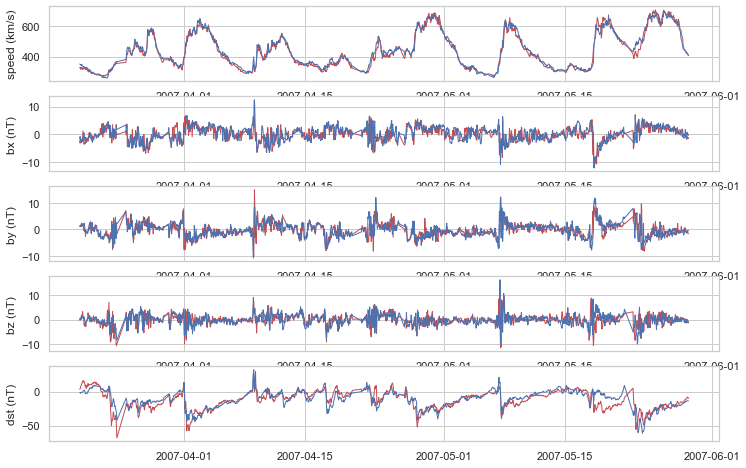

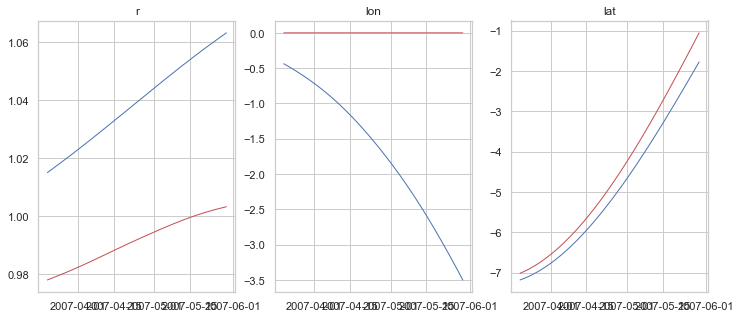

2007-03-19 22:00:00+00:00 2007-07-05 08:00:00+00:00
Data points inside -0.4 < angle < -6.5: 2442
speed -- corr:      0.97 -- offset: 0 hrs
speed -- corr_mean: 0.98 -- corr_std: 0.87
btot -- corr:      0.78 -- offset: 0 hrs
btot -- corr_mean: 0.86 -- corr_std: 0.61
bx -- corr:      0.59 -- offset: 0 hrs
bx -- corr_mean: 0.72 -- corr_std: 0.38
by -- corr:      0.62 -- offset: 0 hrs
by -- corr_mean: 0.75 -- corr_std: 0.50
bz -- corr:      0.40 -- offset: 0 hrs
bz -- corr_mean: 0.55 -- corr_std: 0.64


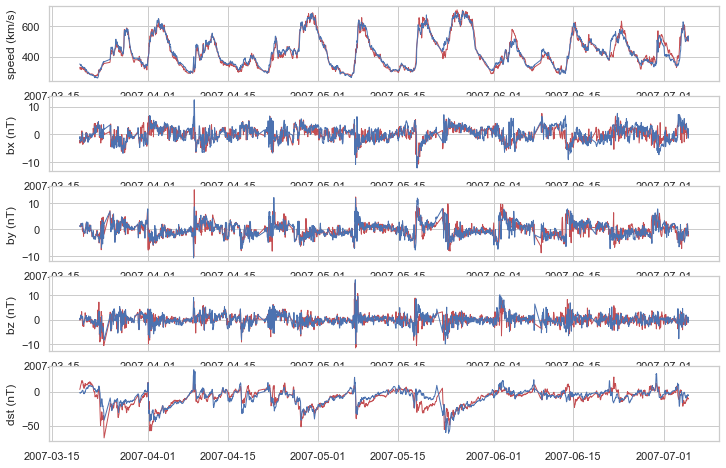

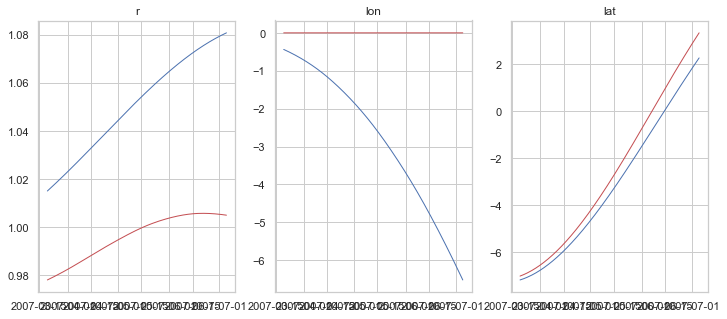

2007-05-13 11:00:00+00:00 2007-08-04 03:00:00+00:00
Data points inside -2.5 < angle < -9.5: 1898
speed -- corr:      0.95 -- offset: 0 hrs
speed -- corr_mean: 0.96 -- corr_std: 0.43
btot -- corr:      0.75 -- offset: 2 hrs
btot -- corr_mean: 0.81 -- corr_std: 0.45
bx -- corr:      0.58 -- offset: 1 hrs
bx -- corr_mean: 0.69 -- corr_std: 0.34
by -- corr:      0.53 -- offset: 1 hrs
by -- corr_mean: 0.65 -- corr_std: 0.36
bz -- corr:      0.15 -- offset: 2 hrs
bz -- corr_mean: 0.27 -- corr_std: 0.44


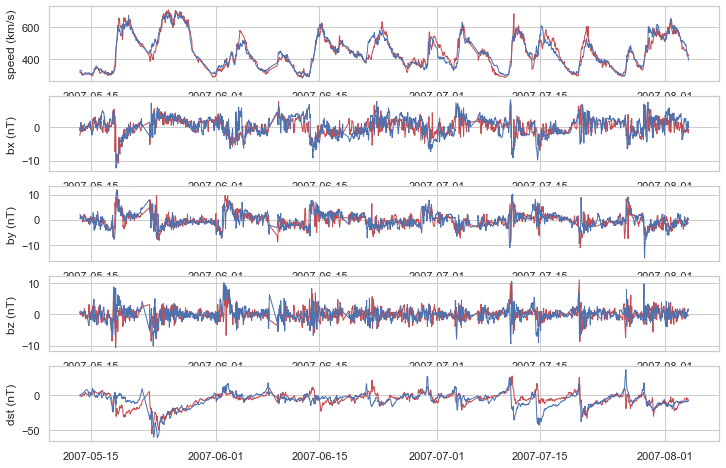

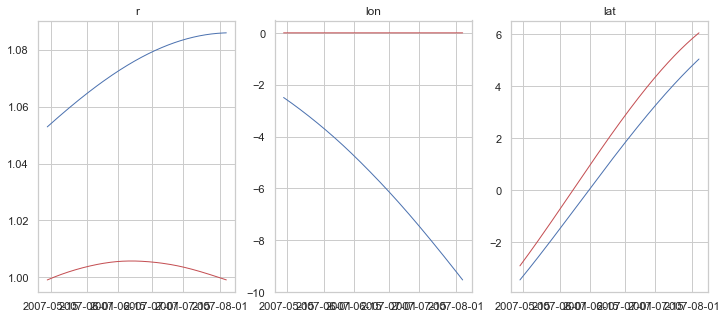

2007-06-24 05:00:00+00:00 2007-08-31 11:00:00+00:00
Data points inside -5.5 < angle < -12.5: 1616
speed -- corr:      0.92 -- offset: 0 hrs
speed -- corr_mean: 0.93 -- corr_std: 0.40
btot -- corr:      0.63 -- offset: 1 hrs
btot -- corr_mean: 0.70 -- corr_std: 0.43
bx -- corr:      0.44 -- offset: -1 hrs
bx -- corr_mean: 0.57 -- corr_std: 0.29
by -- corr:      0.45 -- offset: 1 hrs
by -- corr_mean: 0.57 -- corr_std: 0.42
bz -- corr:      0.10 -- offset: 8 hrs
bz -- corr_mean: 0.19 -- corr_std: 0.38


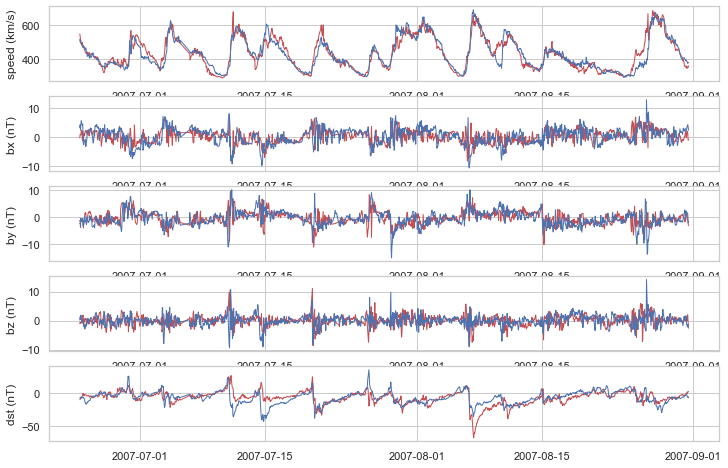

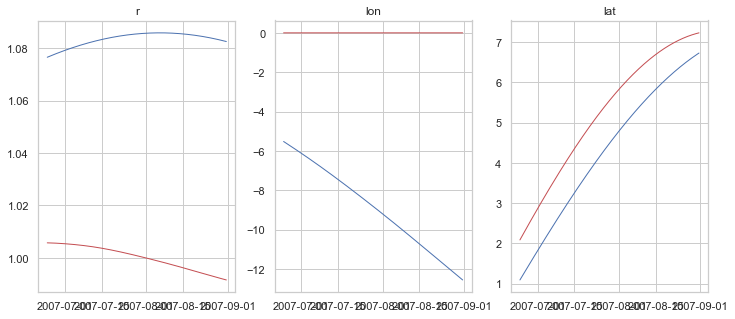

2007-07-25 12:00:00+00:00 2007-09-28 06:00:00+00:00
Data points inside -8.5 < angle < -15.5: 1555
speed -- corr:      0.94 -- offset: 0 hrs
speed -- corr_mean: 0.95 -- corr_std: 0.38
btot -- corr:      0.51 -- offset: 0 hrs
btot -- corr_mean: 0.59 -- corr_std: 0.36
bx -- corr:      0.43 -- offset: -1 hrs
bx -- corr_mean: 0.56 -- corr_std: 0.27
by -- corr:      0.44 -- offset: 1 hrs
by -- corr_mean: 0.57 -- corr_std: 0.30
bz -- corr:      0.12 -- offset: 8 hrs
bz -- corr_mean: 0.24 -- corr_std: 0.30


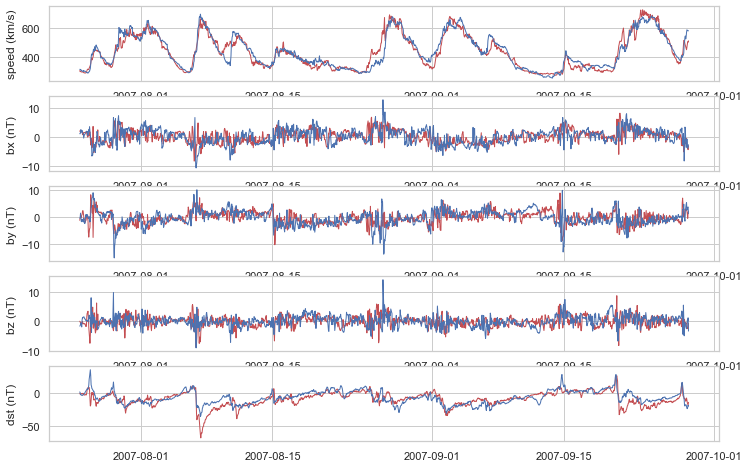

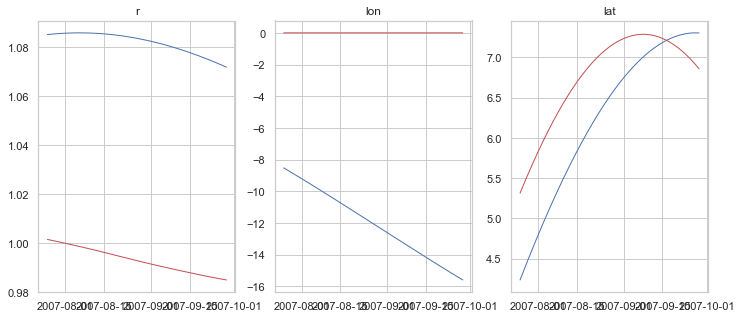

2007-08-22 10:00:00+00:00 2007-10-29 07:00:00+00:00
Data points inside -11.5 < angle < -18.5: 1616
speed -- corr:      0.93 -- offset: 0 hrs
speed -- corr_mean: 0.94 -- corr_std: 0.37
btot -- corr:      0.51 -- offset: 4 hrs
btot -- corr_mean: 0.57 -- corr_std: 0.30
bx -- corr:      0.47 -- offset: 5 hrs
bx -- corr_mean: 0.61 -- corr_std: 0.20
by -- corr:      0.43 -- offset: 0 hrs
by -- corr_mean: 0.56 -- corr_std: 0.31
bz -- corr:      0.13 -- offset: -9 hrs
bz -- corr_mean: 0.27 -- corr_std: 0.29


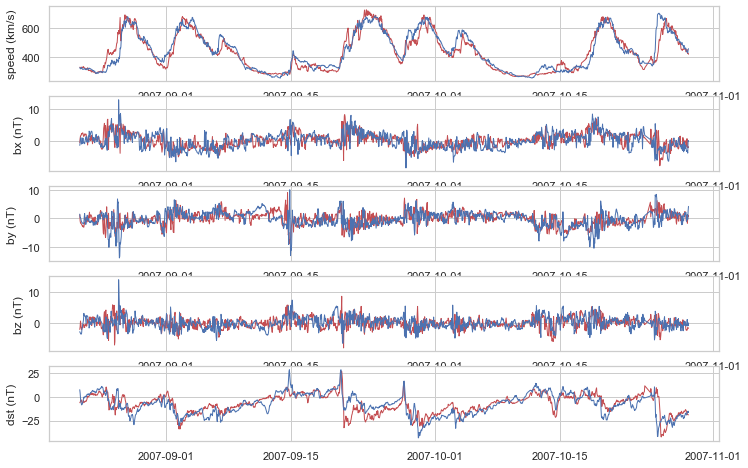

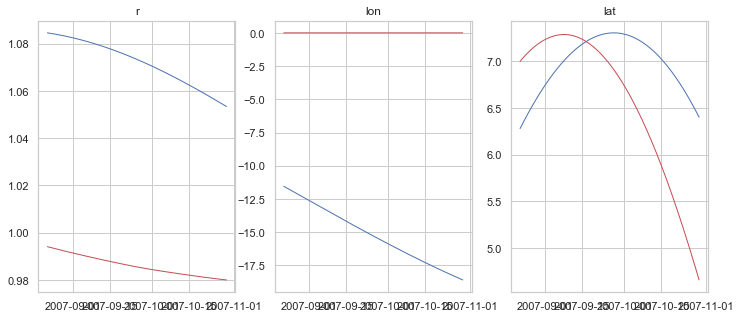

2007-09-18 17:00:00+00:00 2007-12-09 19:00:00+00:00
Data points inside -14.5 < angle < -21.5: 1921
speed -- corr:      0.89 -- offset: 0 hrs
speed -- corr_mean: 0.89 -- corr_std: 0.34
btot -- corr:      0.46 -- offset: 4 hrs
btot -- corr_mean: 0.51 -- corr_std: 0.25
bx -- corr:      0.41 -- offset: -12 hrs
bx -- corr_mean: 0.53 -- corr_std: 0.17
by -- corr:      0.45 -- offset: 1 hrs
by -- corr_mean: 0.56 -- corr_std: 0.18
bz -- corr:      0.09 -- offset: -2 hrs
bz -- corr_mean: 0.17 -- corr_std: 0.26


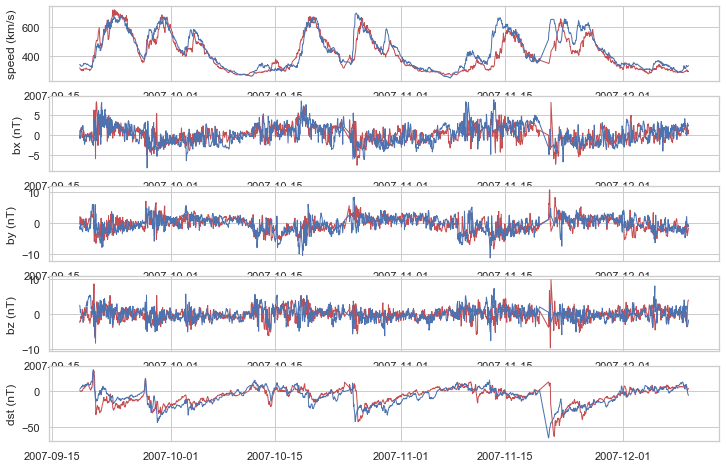

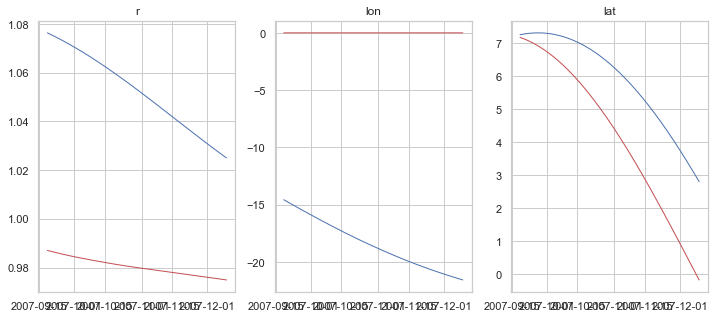

2007-10-18 07:00:00+00:00 2008-05-23 01:00:00+00:00
Data points inside -17.5 < angle < -24.5: 4958
speed -- corr:      0.87 -- offset: 0 hrs
speed -- corr_mean: 0.87 -- corr_std: 0.24
btot -- corr:      0.46 -- offset: 0 hrs
btot -- corr_mean: 0.51 -- corr_std: 0.20
bx -- corr:      0.50 -- offset: -2 hrs
bx -- corr_mean: 0.61 -- corr_std: 0.12
by -- corr:      0.41 -- offset: 8 hrs
by -- corr_mean: 0.52 -- corr_std: 0.16
bz -- corr:      0.06 -- offset: 15 hrs
bz -- corr_mean: 0.10 -- corr_std: 0.28


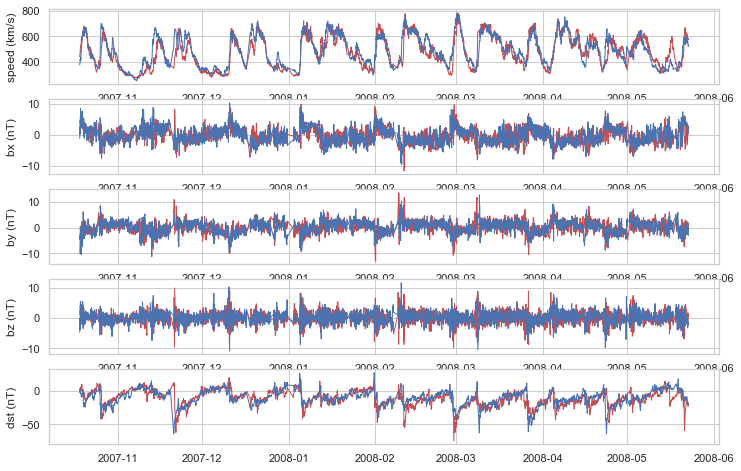

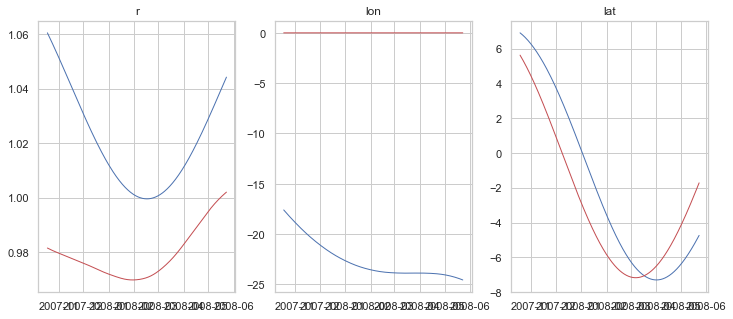

2007-11-24 00:00:00+00:00 2008-07-13 05:00:00+00:00
Data points inside -20.5 < angle < -27.5: 5316
speed -- corr:      0.85 -- offset: 0 hrs
speed -- corr_mean: 0.85 -- corr_std: 0.23
btot -- corr:      0.43 -- offset: 0 hrs
btot -- corr_mean: 0.49 -- corr_std: 0.20
bx -- corr:      0.47 -- offset: -2 hrs
bx -- corr_mean: 0.58 -- corr_std: 0.12
by -- corr:      0.39 -- offset: 8 hrs
by -- corr_mean: 0.50 -- corr_std: 0.17
bz -- corr:      0.04 -- offset: 15 hrs
bz -- corr_mean: 0.07 -- corr_std: 0.27


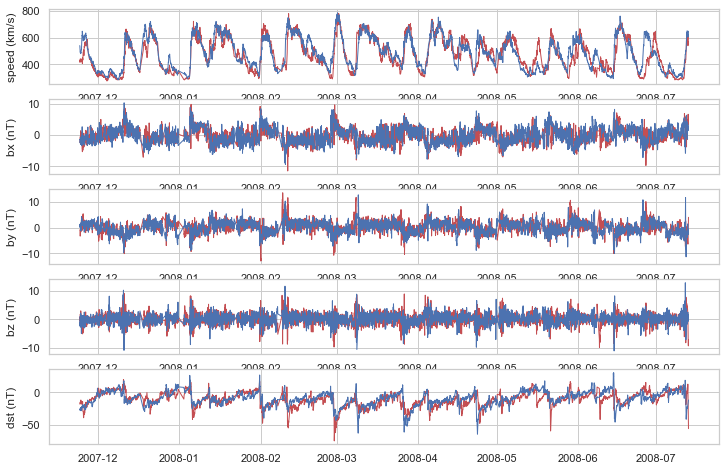

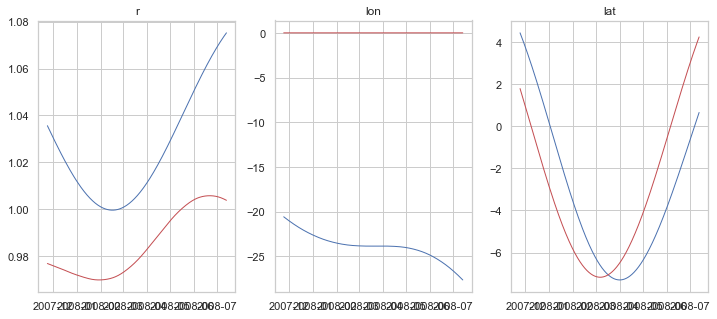

2008-01-31 12:00:00+00:00 2008-08-12 09:00:00+00:00
Data points inside -23.5 < angle < -30.5: 4509
speed -- corr:      0.84 -- offset: 0 hrs
speed -- corr_mean: 0.84 -- corr_std: 0.19
btot -- corr:      0.38 -- offset: 0 hrs
btot -- corr_mean: 0.44 -- corr_std: 0.19
bx -- corr:      0.45 -- offset: -2 hrs
bx -- corr_mean: 0.55 -- corr_std: 0.11
by -- corr:      0.40 -- offset: 3 hrs
by -- corr_mean: 0.51 -- corr_std: 0.16
bz -- corr:      0.05 -- offset: 14 hrs
bz -- corr_mean: 0.09 -- corr_std: 0.20


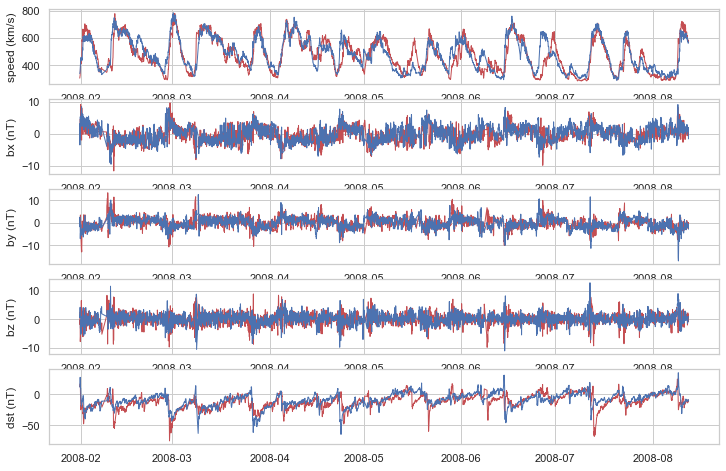

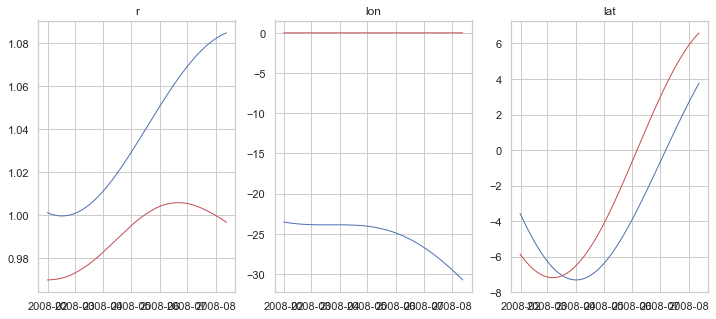

2008-06-30 17:00:00+00:00 2008-09-06 23:00:00+00:00
Data points inside -26.5 < angle < -33.5: 1599
speed -- corr:      0.92 -- offset: 0 hrs
speed -- corr_mean: 0.93 -- corr_std: 0.41
btot -- corr:      0.50 -- offset: -3 hrs
btot -- corr_mean: 0.57 -- corr_std: 0.34
bx -- corr:      0.38 -- offset: 6 hrs
bx -- corr_mean: 0.47 -- corr_std: 0.16
by -- corr:      0.36 -- offset: 3 hrs
by -- corr_mean: 0.46 -- corr_std: 0.25
bz -- corr:      0.07 -- offset: -5 hrs
bz -- corr_mean: 0.14 -- corr_std: 0.30


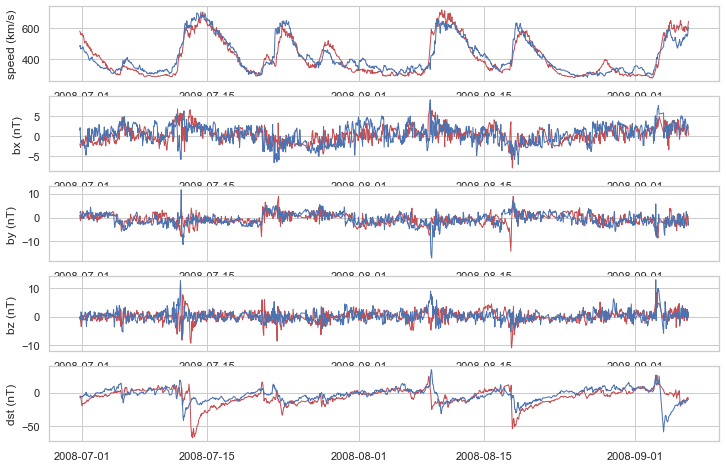

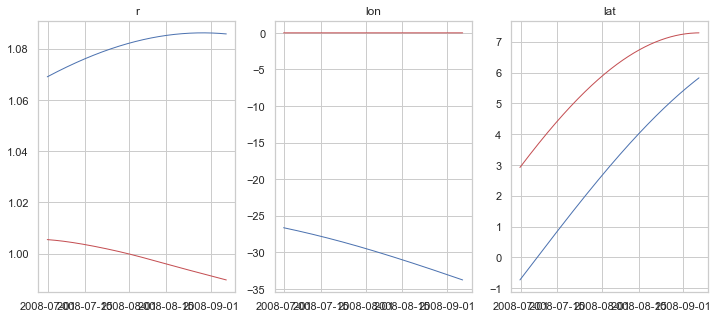

2008-08-02 23:00:00+00:00 2008-10-01 11:00:00+00:00
Data points inside -29.5 < angle < -36.5: 1351
speed -- corr:      0.94 -- offset: 0 hrs
speed -- corr_mean: 0.94 -- corr_std: 0.44
btot -- corr:      0.51 -- offset: -4 hrs
btot -- corr_mean: 0.58 -- corr_std: 0.33
bx -- corr:      0.34 -- offset: 5 hrs
bx -- corr_mean: 0.41 -- corr_std: 0.17
by -- corr:      0.25 -- offset: 18 hrs
by -- corr_mean: 0.33 -- corr_std: 0.18
bz -- corr:      0.15 -- offset: -6 hrs
bz -- corr_mean: 0.22 -- corr_std: 0.30


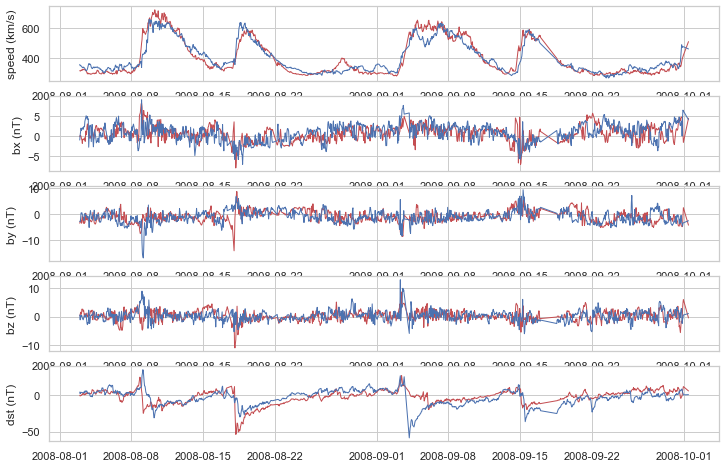

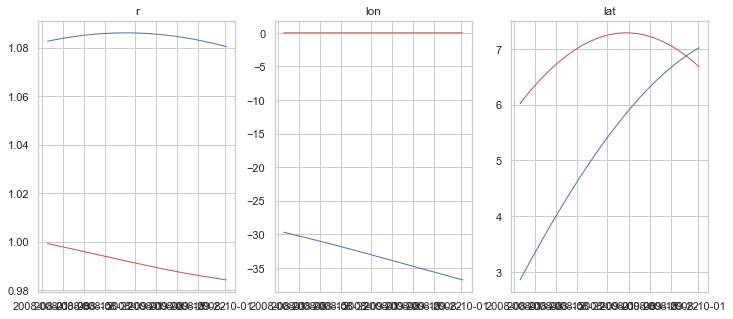

2008-08-29 13:00:00+00:00 2008-10-27 01:00:00+00:00
Data points inside -32.5 < angle < -39.5: 1260
speed -- corr:      0.95 -- offset: 0 hrs
speed -- corr_mean: 0.95 -- corr_std: 0.39
btot -- corr:      0.52 -- offset: 0 hrs
btot -- corr_mean: 0.60 -- corr_std: 0.34
bx -- corr:      0.32 -- offset: 6 hrs
bx -- corr_mean: 0.40 -- corr_std: 0.18
by -- corr:      0.27 -- offset: 10 hrs
by -- corr_mean: 0.37 -- corr_std: 0.24
bz -- corr:      0.17 -- offset: 0 hrs
bz -- corr_mean: 0.25 -- corr_std: 0.32


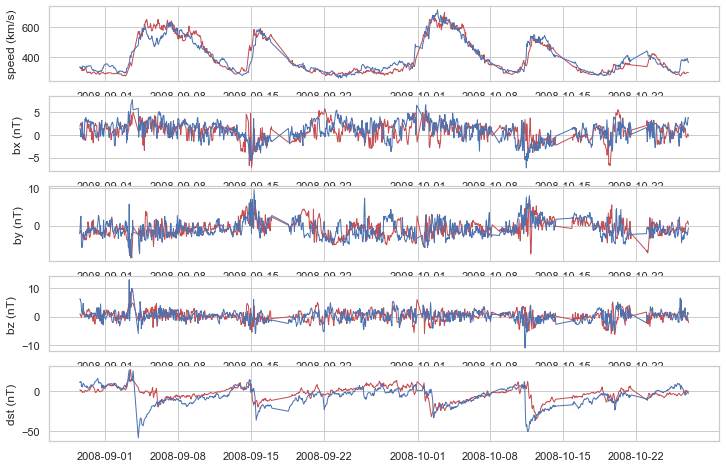

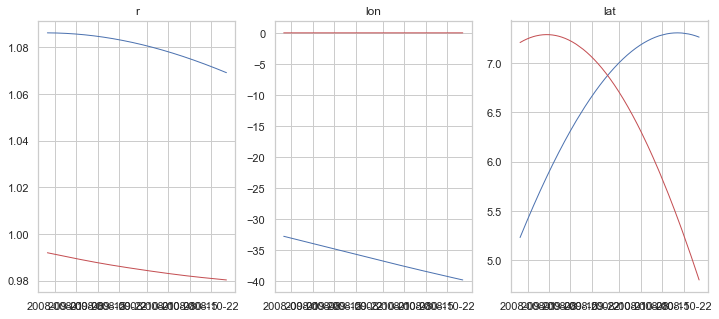

2008-09-23 01:00:00+00:00 2008-11-25 21:00:00+00:00
Data points inside -35.5 < angle < -42.5: 1421
speed -- corr:      0.91 -- offset: 0 hrs
speed -- corr_mean: 0.91 -- corr_std: 0.46
btot -- corr:      0.50 -- offset: 0 hrs
btot -- corr_mean: 0.56 -- corr_std: 0.33
bx -- corr:      0.32 -- offset: -1 hrs
bx -- corr_mean: 0.39 -- corr_std: 0.23
by -- corr:      0.27 -- offset: 17 hrs
by -- corr_mean: 0.35 -- corr_std: 0.26
bz -- corr:      0.06 -- offset: -17 hrs
bz -- corr_mean: 0.11 -- corr_std: 0.31


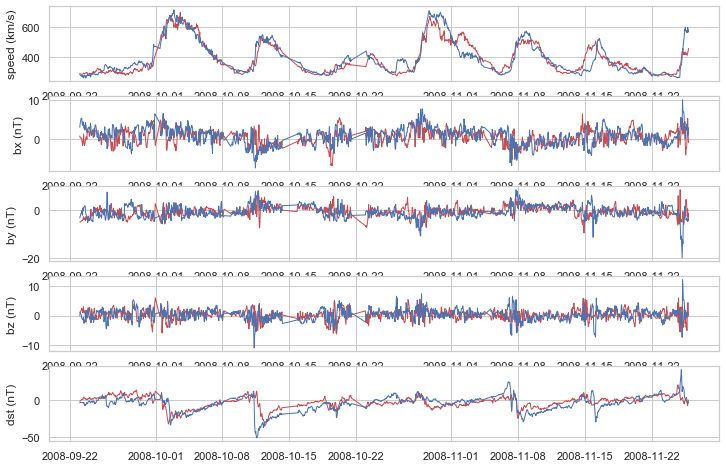

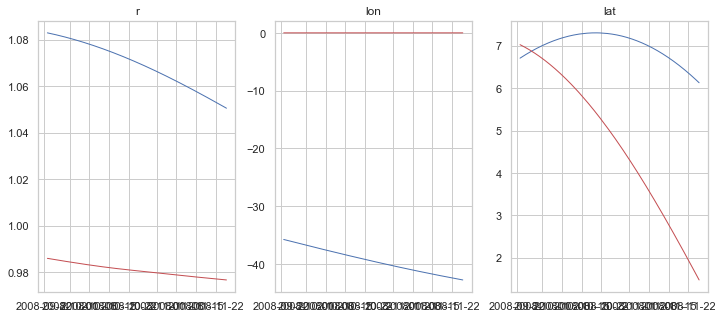

2008-10-18 04:00:00+00:00 2009-01-03 08:00:00+00:00
Data points inside -38.5 < angle < -45.5: 1731
speed -- corr:      0.77 -- offset: 0 hrs
speed -- corr_mean: 0.78 -- corr_std: 0.37
btot -- corr:      0.45 -- offset: -3 hrs
btot -- corr_mean: 0.50 -- corr_std: 0.33
bx -- corr:      0.40 -- offset: 0 hrs
bx -- corr_mean: 0.50 -- corr_std: 0.20
by -- corr:      0.29 -- offset: 4 hrs
by -- corr_mean: 0.37 -- corr_std: 0.17
bz -- corr:      0.05 -- offset: -265 hrs
bz -- corr_mean: 0.08 -- corr_std: 0.29


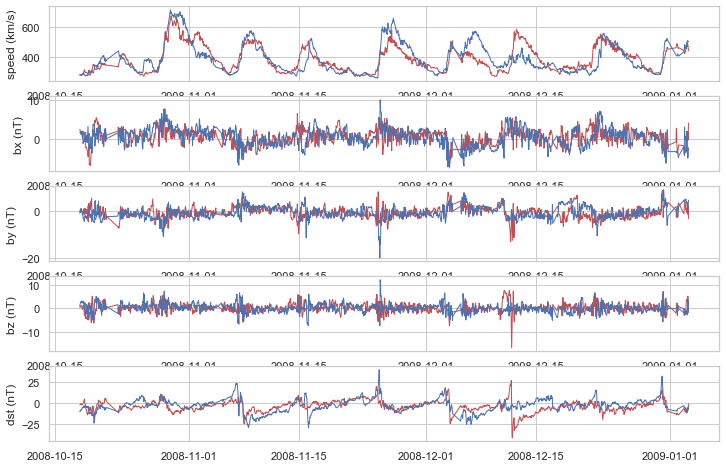

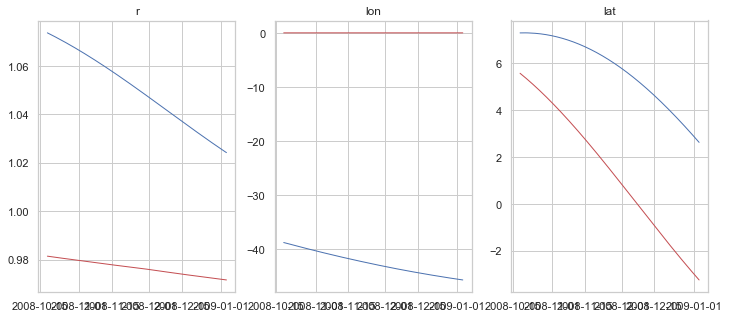

2008-11-15 09:00:00+00:00 2009-07-18 00:00:00+00:00
Data points inside -41.5 < angle < -48.5: 5412
speed -- corr:      0.58 -- offset: 0 hrs
speed -- corr_mean: 0.59 -- corr_std: 0.22
btot -- corr:      0.18 -- offset: 10 hrs
btot -- corr_mean: 0.21 -- corr_std: 0.11
bx -- corr:      0.26 -- offset: 3 hrs
bx -- corr_mean: 0.33 -- corr_std: 0.10
by -- corr:      0.24 -- offset: 4 hrs
by -- corr_mean: 0.30 -- corr_std: 0.08
bz -- corr:      0.04 -- offset: -755 hrs
bz -- corr_mean: 0.06 -- corr_std: 0.16


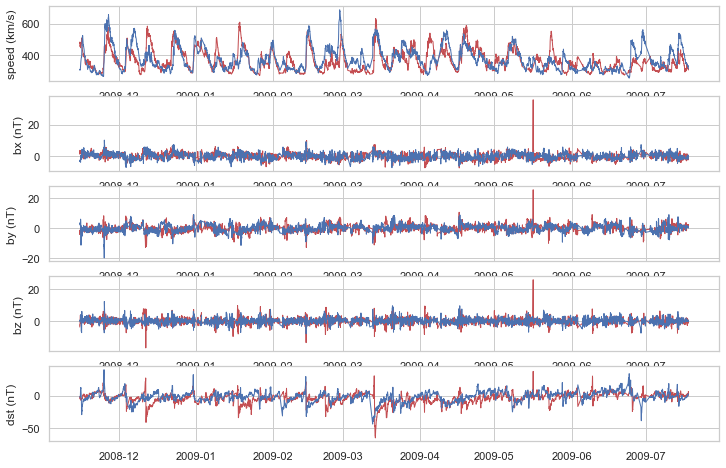

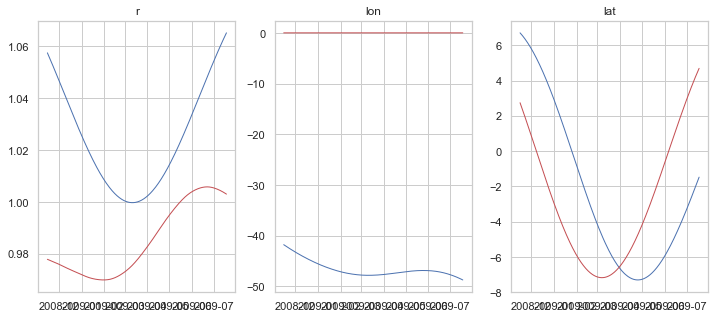

2008-12-20 00:00:00+00:00 2009-08-20 10:00:00+00:00
Data points inside -44.5 < angle < -51.5: 5262
speed -- corr:      0.56 -- offset: 0 hrs
speed -- corr_mean: 0.56 -- corr_std: 0.17
btot -- corr:      0.17 -- offset: 6 hrs
btot -- corr_mean: 0.20 -- corr_std: 0.10
bx -- corr:      0.24 -- offset: 3 hrs
bx -- corr_mean: 0.31 -- corr_std: 0.10
by -- corr:      0.23 -- offset: 4 hrs
by -- corr_mean: 0.28 -- corr_std: 0.08
bz -- corr:      0.05 -- offset: 1357 hrs
bz -- corr_mean: 0.08 -- corr_std: 0.18


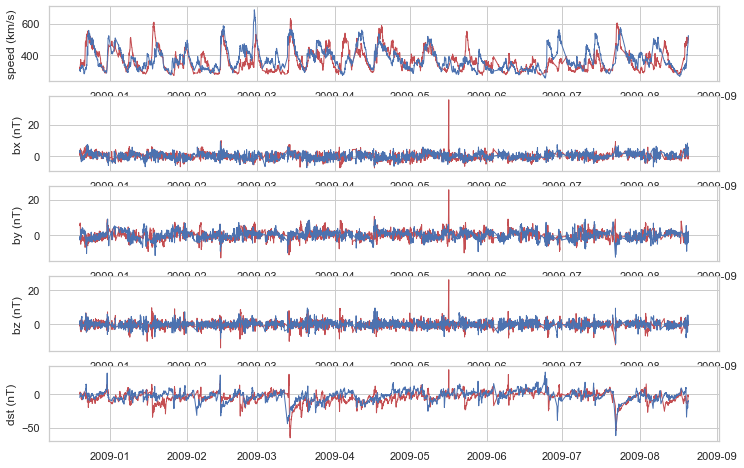

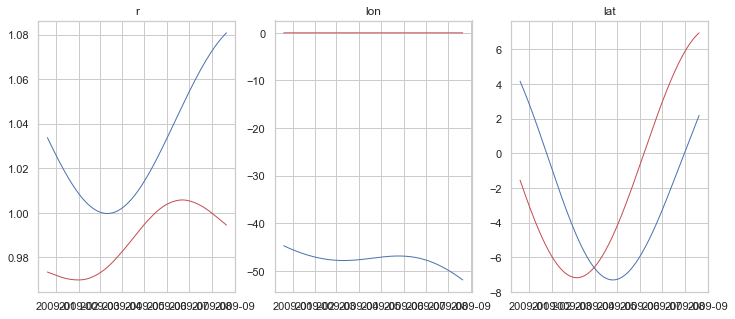

2009-02-16 23:00:00+00:00 2009-09-13 08:00:00+00:00
Data points inside -47.5 < angle < -54.4: 2780
speed -- corr:      0.53 -- offset: 0 hrs
speed -- corr_mean: 0.53 -- corr_std: 0.15
btot -- corr:      0.22 -- offset: 0 hrs
btot -- corr_mean: 0.17 -- corr_std: 0.07
bx -- corr:      0.27 -- offset: -9 hrs
bx -- corr_mean: 0.33 -- corr_std: 0.11
by -- corr:      0.21 -- offset: -16 hrs
by -- corr_mean: 0.24 -- corr_std: 0.08
bz -- corr:      0.04 -- offset: -13 hrs
bz -- corr_mean: 0.08 -- corr_std: 0.15


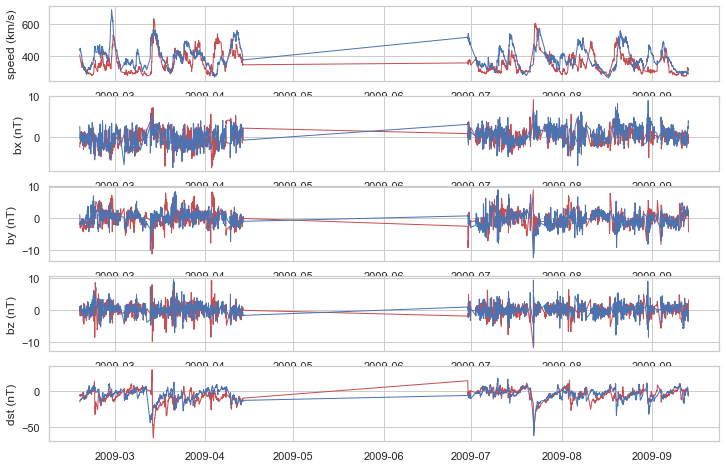

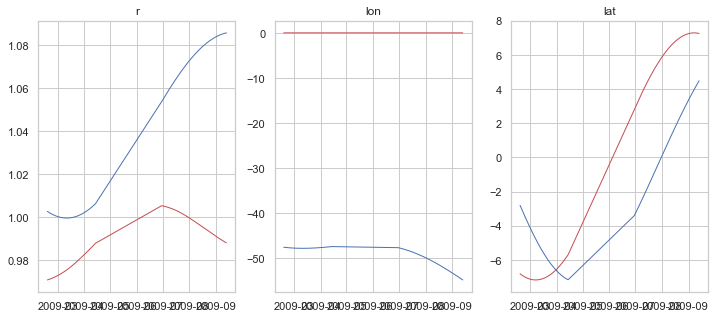

2009-08-10 21:00:00+00:00 2009-10-06 12:00:00+00:00
Data points inside -50.5 < angle < -57.4: 1207
speed -- corr:      0.54 -- offset: 0 hrs
speed -- corr_mean: 0.54 -- corr_std: 0.18
btot -- corr:      0.21 -- offset: -12 hrs
btot -- corr_mean: 0.24 -- corr_std: 0.04
bx -- corr:      0.30 -- offset: -3 hrs
bx -- corr_mean: 0.38 -- corr_std: 0.10
by -- corr:      0.21 -- offset: -10 hrs
by -- corr_mean: 0.27 -- corr_std: 0.12
bz -- corr:      0.13 -- offset: 5 hrs
bz -- corr_mean: 0.17 -- corr_std: 0.11


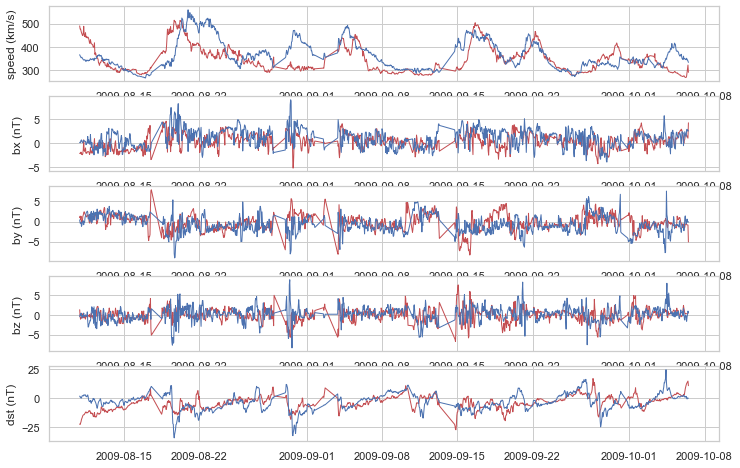

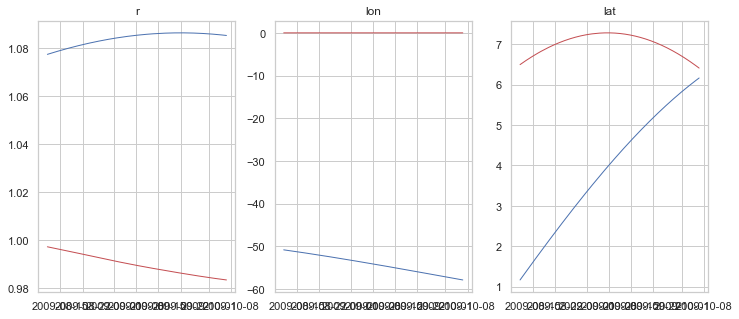

2009-09-06 10:00:00+00:00 2009-10-30 01:00:00+00:00
Data points inside -53.5 < angle < -60.5: 1126
speed -- corr:      0.59 -- offset: 0 hrs
speed -- corr_mean: 0.59 -- corr_std: 0.17
btot -- corr:      0.03 -- offset: -14 hrs
btot -- corr_mean: 0.04 -- corr_std: 0.01
bx -- corr:      0.19 -- offset: -21 hrs
bx -- corr_mean: 0.24 -- corr_std: 0.01
by -- corr:      0.14 -- offset: -10 hrs
by -- corr_mean: 0.17 -- corr_std: 0.01
bz -- corr:      0.11 -- offset: -296 hrs
bz -- corr_mean: 0.14 -- corr_std: 0.05


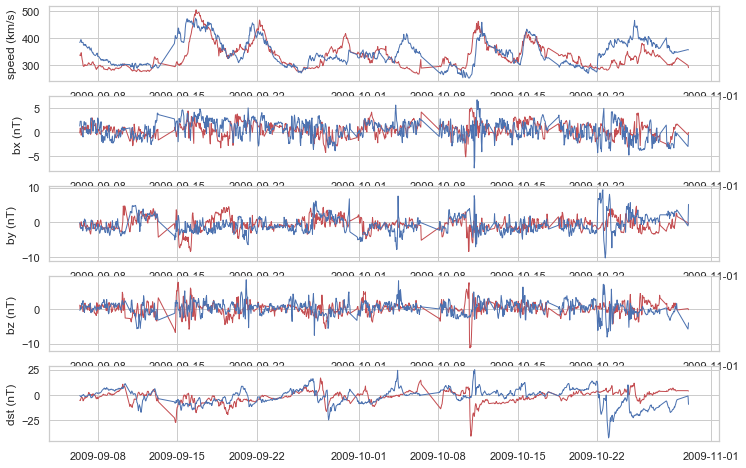

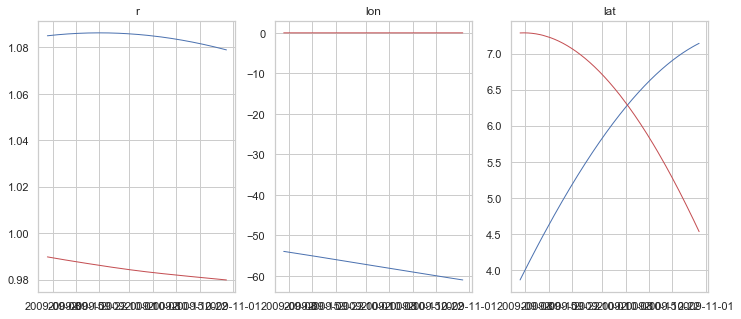

2009-09-29 18:00:00+00:00 2009-11-23 20:00:00+00:00
Data points inside -56.5 < angle < -63.5: 1127
speed -- corr:      0.53 -- offset: 0 hrs
speed -- corr_mean: 0.53 -- corr_std: 0.20
btot -- corr:      -0.01 -- offset: -18 hrs
btot -- corr_mean: 0.00 -- corr_std: 0.05
bx -- corr:      0.10 -- offset: 84 hrs
bx -- corr_mean: 0.14 -- corr_std: 0.02
by -- corr:      -0.01 -- offset: -148 hrs
by -- corr_mean: -0.02 -- corr_std: -0.02
bz -- corr:      0.04 -- offset: -305 hrs
bz -- corr_mean: 0.03 -- corr_std: 0.02


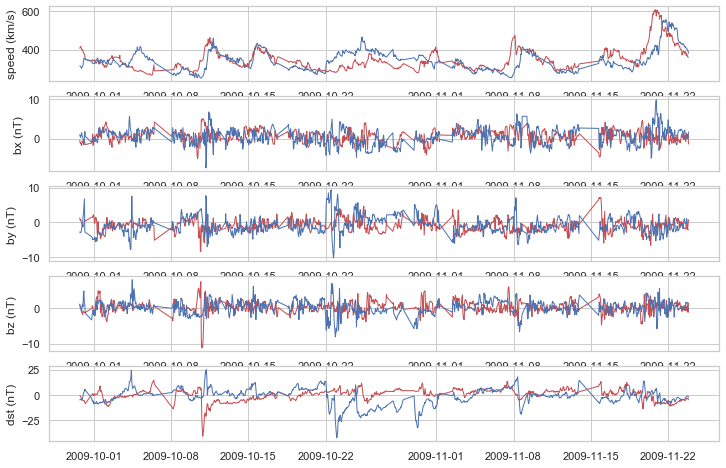

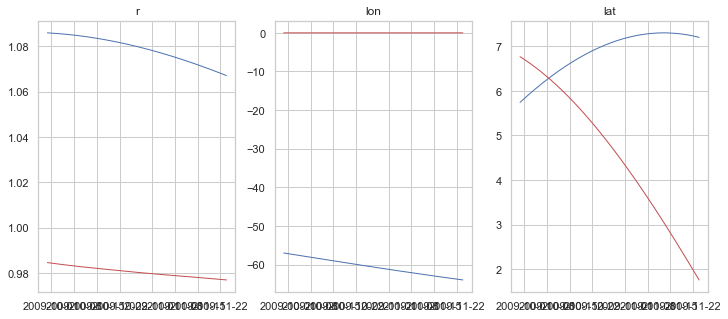

2009-10-22 09:00:00+00:00 2009-12-22 01:00:00+00:00
Data points inside -59.5 < angle < -66.5: 1231
speed -- corr:      0.49 -- offset: 0 hrs
speed -- corr_mean: 0.49 -- corr_std: 0.18
btot -- corr:      0.01 -- offset: -17 hrs
btot -- corr_mean: 0.02 -- corr_std: 0.11
bx -- corr:      0.14 -- offset: -30 hrs
bx -- corr_mean: 0.20 -- corr_std: 0.02
by -- corr:      0.09 -- offset: -33 hrs
by -- corr_mean: 0.11 -- corr_std: -0.02
bz -- corr:      0.04 -- offset: -103 hrs
bz -- corr_mean: 0.02 -- corr_std: 0.08


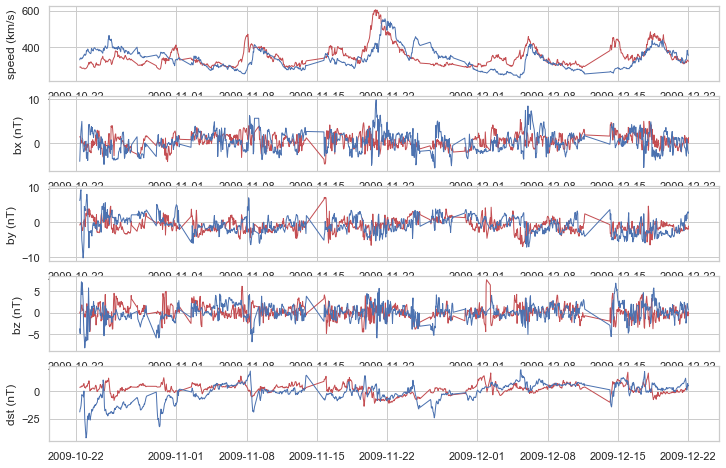

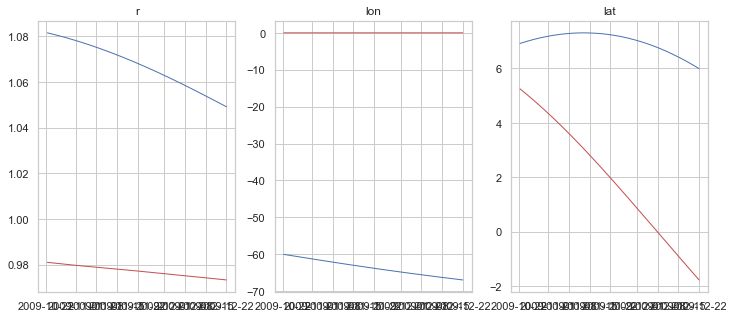

2009-11-15 17:00:00+00:00 2010-07-04 03:00:00+00:00
Data points inside -62.5 < angle < -69.5: 1686
speed -- corr:      0.66 -- offset: 0 hrs
speed -- corr_mean: 0.52 -- corr_std: 0.16
btot -- corr:      0.24 -- offset: -16 hrs
btot -- corr_mean: 0.25 -- corr_std: 0.14
bx -- corr:      0.21 -- offset: -82 hrs
bx -- corr_mean: 0.44 -- corr_std: 0.12
by -- corr:      0.18 -- offset: -39 hrs
by -- corr_mean: 0.40 -- corr_std: 0.08
bz -- corr:      0.03 -- offset: 33 hrs
bz -- corr_mean: 0.04 -- corr_std: 0.11


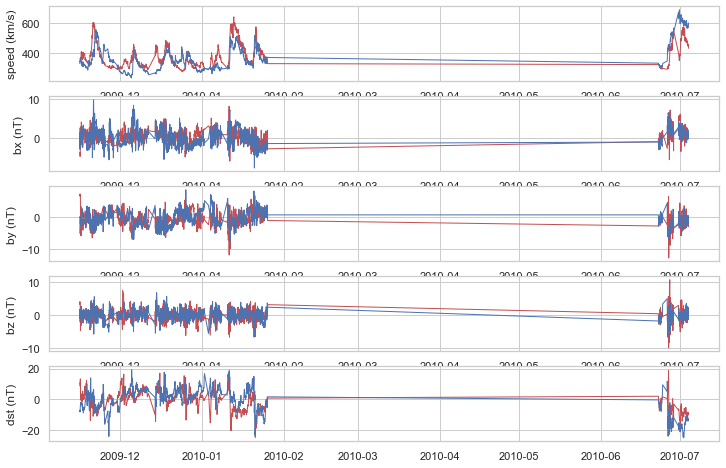

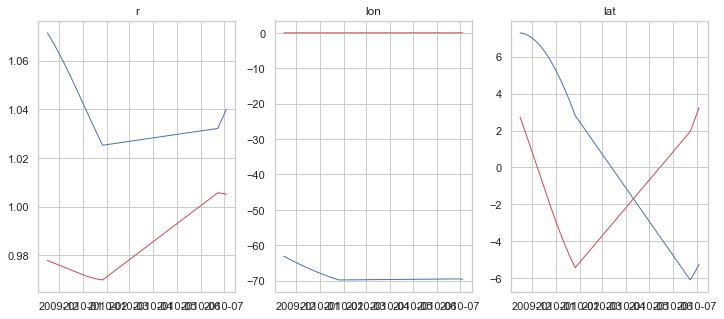

2009-12-14 05:00:00+00:00 2010-08-26 19:00:00+00:00
Data points inside -65.7 < angle < -72.5: 5352
speed -- corr:      0.48 -- offset: 0 hrs
speed -- corr_mean: 0.48 -- corr_std: 0.14
btot -- corr:      0.19 -- offset: -2 hrs
btot -- corr_mean: 0.21 -- corr_std: 0.13
bx -- corr:      0.38 -- offset: -8 hrs
bx -- corr_mean: 0.45 -- corr_std: 0.12
by -- corr:      0.29 -- offset: -2 hrs
by -- corr_mean: 0.35 -- corr_std: 0.10
bz -- corr:      0.00 -- offset: 54 hrs
bz -- corr_mean: 0.02 -- corr_std: 0.13


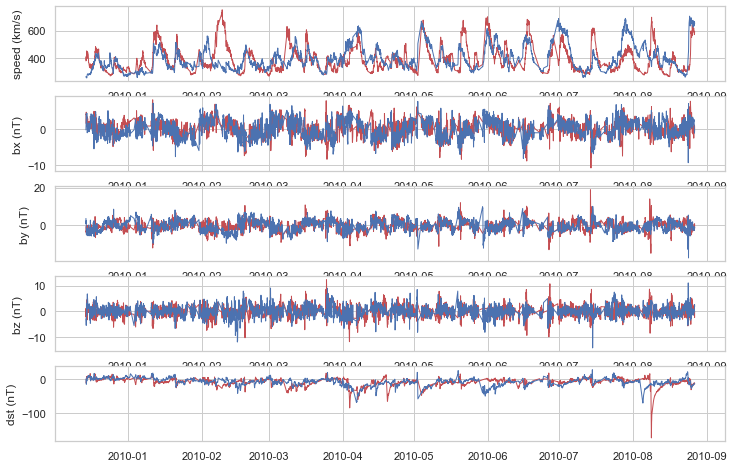

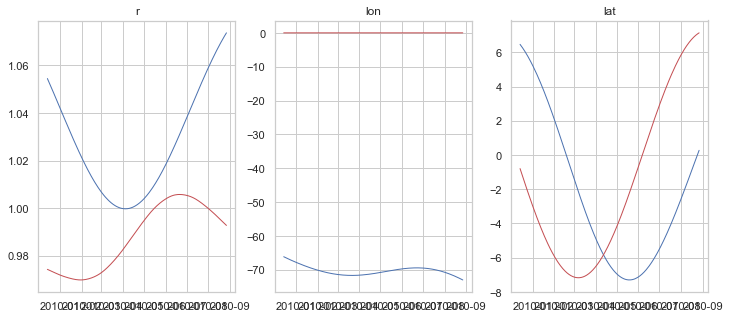

2010-01-13 16:00:00+00:00 2010-09-21 18:00:00+00:00
Data points inside -68.5 < angle < -75.5: 5277
speed -- corr:      0.49 -- offset: 0 hrs
speed -- corr_mean: 0.49 -- corr_std: 0.13
btot -- corr:      0.18 -- offset: 0 hrs
btot -- corr_mean: 0.20 -- corr_std: 0.11
bx -- corr:      0.39 -- offset: 2 hrs
bx -- corr_mean: 0.46 -- corr_std: 0.09
by -- corr:      0.29 -- offset: -5 hrs
by -- corr_mean: 0.36 -- corr_std: 0.09
bz -- corr:      0.02 -- offset: 694 hrs
bz -- corr_mean: 0.05 -- corr_std: 0.11


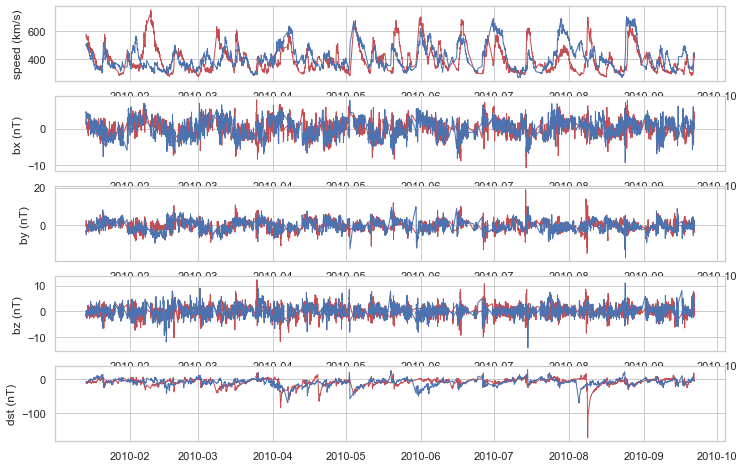

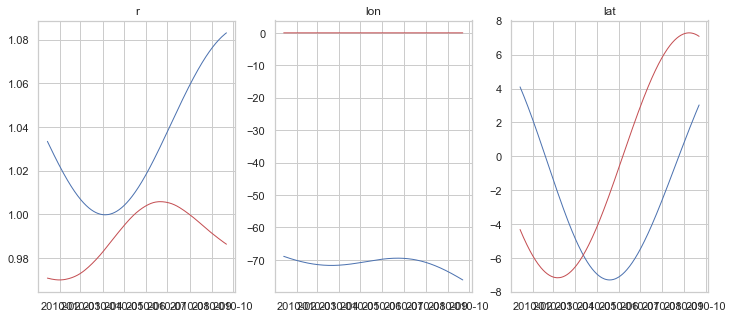

2010-03-09 10:00:00+00:00 2010-10-14 04:00:00+00:00
Data points inside -71.5 < angle < -78.5: 2049
speed -- corr:      0.67 -- offset: 0 hrs
speed -- corr_mean: 0.57 -- corr_std: 0.16
btot -- corr:      0.18 -- offset: 20 hrs
btot -- corr_mean: 0.21 -- corr_std: 0.09
bx -- corr:      0.27 -- offset: -28 hrs
bx -- corr_mean: 0.42 -- corr_std: 0.09
by -- corr:      0.24 -- offset: -46 hrs
by -- corr_mean: 0.35 -- corr_std: 0.10
bz -- corr:      0.02 -- offset: -26 hrs
bz -- corr_mean: 0.02 -- corr_std: 0.12


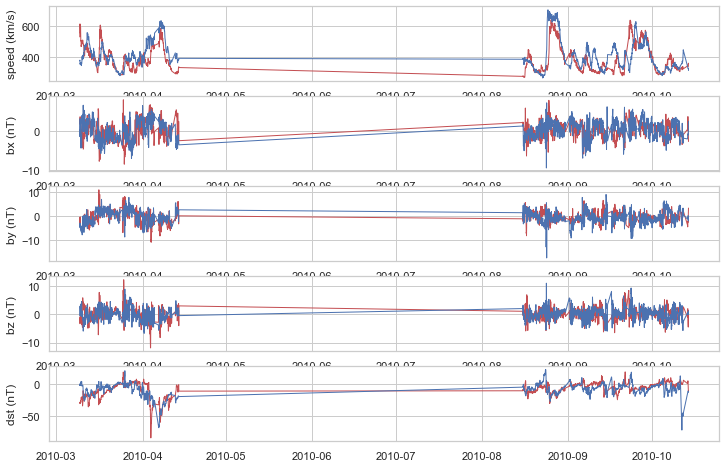

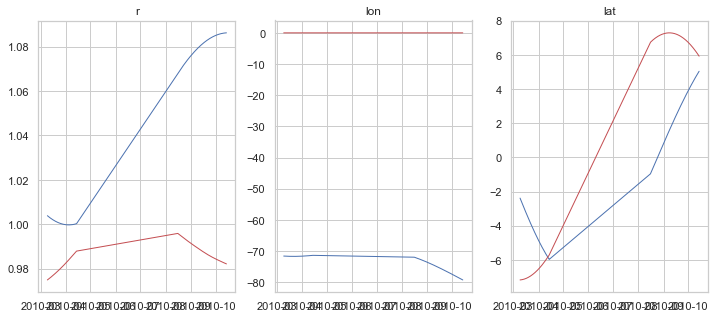

2010-09-13 18:00:00+00:00 2010-11-04 15:00:00+00:00
Data points inside -74.5 < angle < -81.5: 1059
speed -- corr:      0.80 -- offset: 0 hrs
speed -- corr_mean: 0.80 -- corr_std: 0.23
btot -- corr:      0.11 -- offset: -21 hrs
btot -- corr_mean: 0.12 -- corr_std: 0.17
bx -- corr:      0.15 -- offset: 5 hrs
bx -- corr_mean: 0.19 -- corr_std: 0.14
by -- corr:      0.19 -- offset: -11 hrs
by -- corr_mean: 0.25 -- corr_std: 0.05
bz -- corr:      -0.01 -- offset: -8 hrs
bz -- corr_mean: -0.01 -- corr_std: 0.04


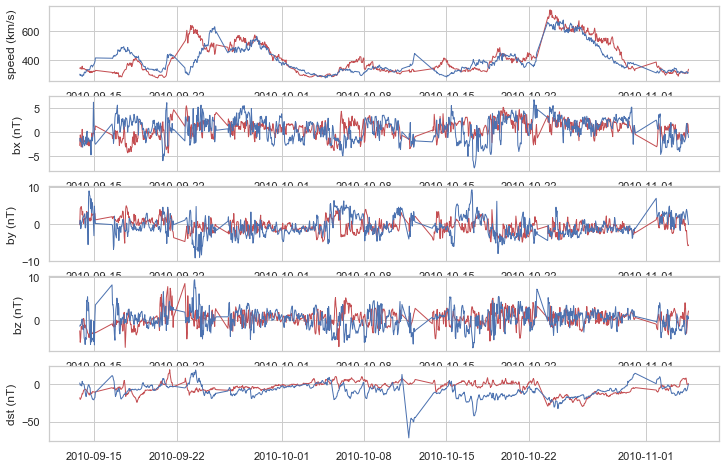

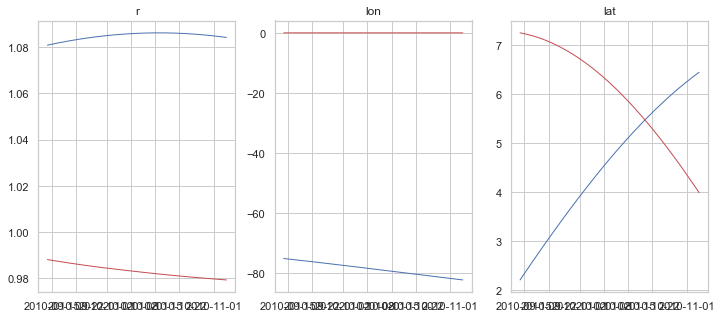

2010-10-06 23:00:00+00:00 2010-11-25 19:00:00+00:00
Data points inside -77.5 < angle < -84.4: 1033
speed -- corr:      0.77 -- offset: 0 hrs
speed -- corr_mean: 0.78 -- corr_std: 0.10
btot -- corr:      -0.01 -- offset: 67 hrs
btot -- corr_mean: -0.01 -- corr_std: 0.03
bx -- corr:      0.26 -- offset: -7 hrs
bx -- corr_mean: 0.32 -- corr_std: 0.08
by -- corr:      0.34 -- offset: -9 hrs
by -- corr_mean: 0.41 -- corr_std: 0.07
bz -- corr:      -0.02 -- offset: -15 hrs
bz -- corr_mean: -0.04 -- corr_std: 0.10


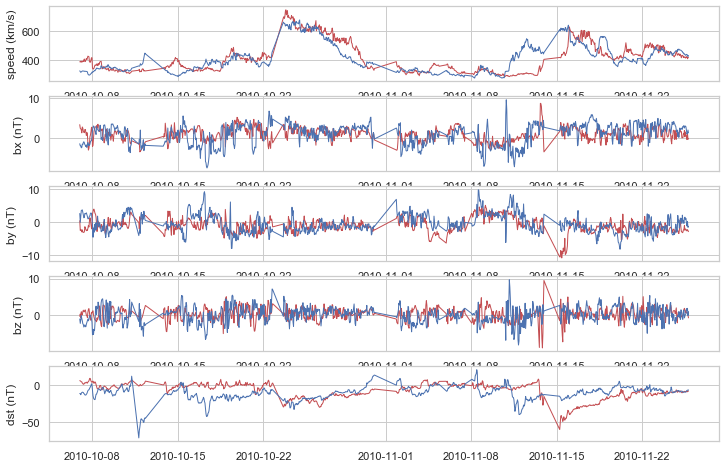

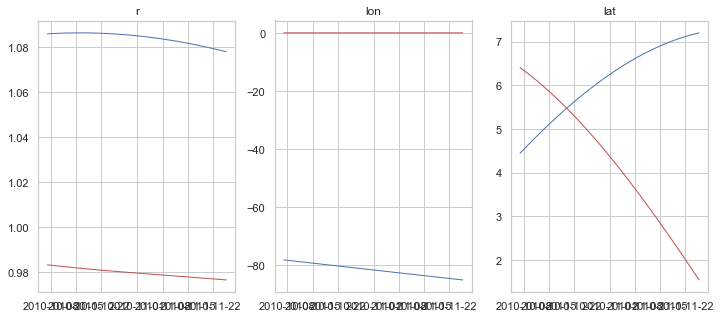

2010-10-28 16:00:00+00:00 2010-12-19 20:00:00+00:00
Data points inside -80.5 < angle < -87.4: 1046
speed -- corr:      0.53 -- offset: 0 hrs
speed -- corr_mean: 0.54 -- corr_std: 0.16
btot -- corr:      0.10 -- offset: 71 hrs
btot -- corr_mean: 0.11 -- corr_std: 0.00
bx -- corr:      0.40 -- offset: -23 hrs
bx -- corr_mean: 0.46 -- corr_std: 0.06
by -- corr:      0.34 -- offset: 8 hrs
by -- corr_mean: 0.41 -- corr_std: 0.10
bz -- corr:      -0.04 -- offset: 613 hrs
bz -- corr_mean: -0.07 -- corr_std: 0.14


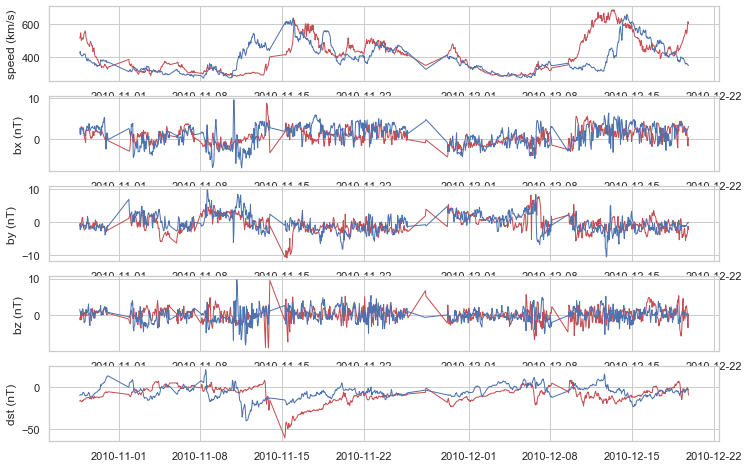

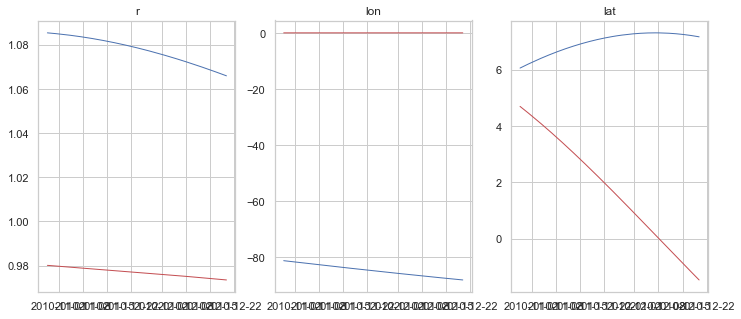

2010-11-19 07:00:00+00:00 2011-01-16 02:00:00+00:00
Data points inside -83.5 < angle < -90.5: 1182
speed -- corr:      0.63 -- offset: 0 hrs
speed -- corr_mean: 0.63 -- corr_std: 0.23
btot -- corr:      0.19 -- offset: 2 hrs
btot -- corr_mean: 0.22 -- corr_std: 0.02
bx -- corr:      0.34 -- offset: -15 hrs
bx -- corr_mean: 0.42 -- corr_std: -0.05
by -- corr:      0.28 -- offset: 9 hrs
by -- corr_mean: 0.36 -- corr_std: 0.11
bz -- corr:      -0.00 -- offset: 124 hrs
bz -- corr_mean: 0.02 -- corr_std: 0.11


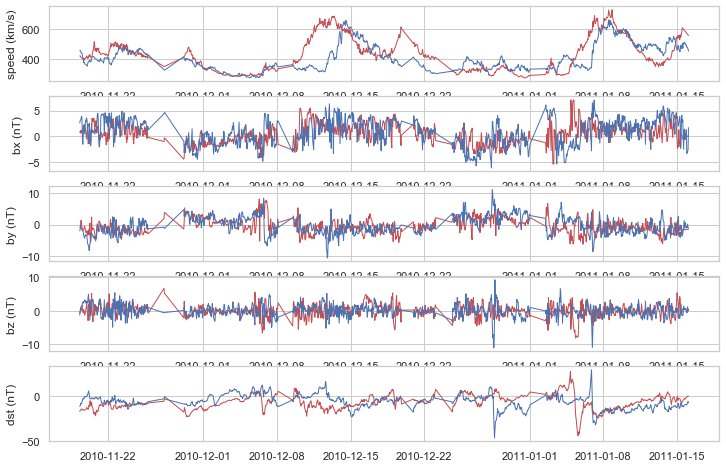

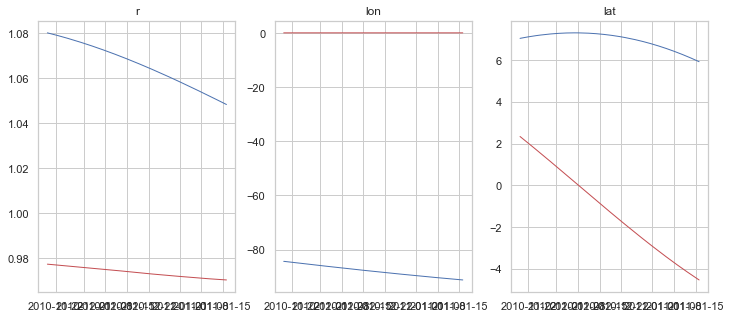

2010-12-12 10:00:00+00:00 2011-08-28 21:00:00+00:00
Data points inside -86.5 < angle < -93.5: 3194
speed -- corr:      0.55 -- offset: 0 hrs
speed -- corr_mean: 0.55 -- corr_std: 0.12
btot -- corr:      0.16 -- offset: 57 hrs
btot -- corr_mean: 0.17 -- corr_std: 0.10
bx -- corr:      0.31 -- offset: 8 hrs
bx -- corr_mean: 0.41 -- corr_std: 0.01
by -- corr:      0.27 -- offset: 12 hrs
by -- corr_mean: 0.36 -- corr_std: 0.06
bz -- corr:      0.04 -- offset: 37 hrs
bz -- corr_mean: 0.15 -- corr_std: 0.10


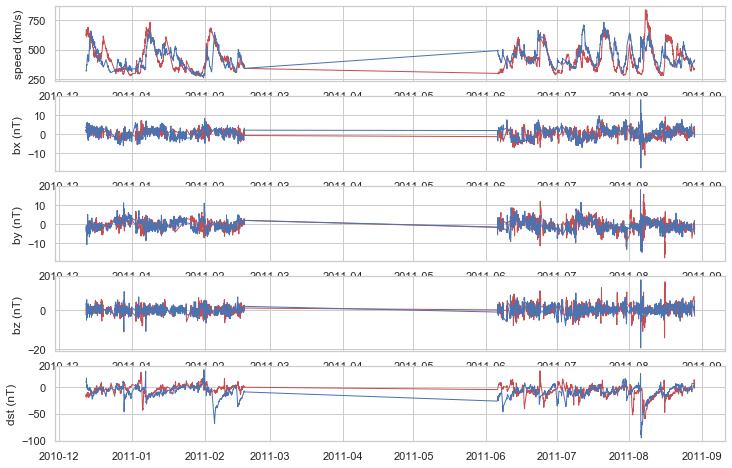

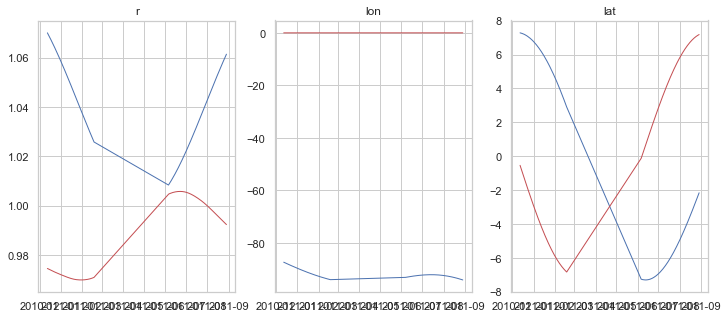

2011-01-06 20:00:00+00:00 2011-09-28 04:00:00+00:00
Data points inside -89.5 < angle < -96.5: 5188
speed -- corr:      0.53 -- offset: 0 hrs
speed -- corr_mean: 0.54 -- corr_std: 0.12
btot -- corr:      0.16 -- offset: 22 hrs
btot -- corr_mean: 0.17 -- corr_std: 0.12
bx -- corr:      0.37 -- offset: 0 hrs
bx -- corr_mean: 0.43 -- corr_std: 0.02
by -- corr:      0.28 -- offset: 7 hrs
by -- corr_mean: 0.36 -- corr_std: 0.08
bz -- corr:      0.11 -- offset: -2 hrs
bz -- corr_mean: 0.16 -- corr_std: 0.09


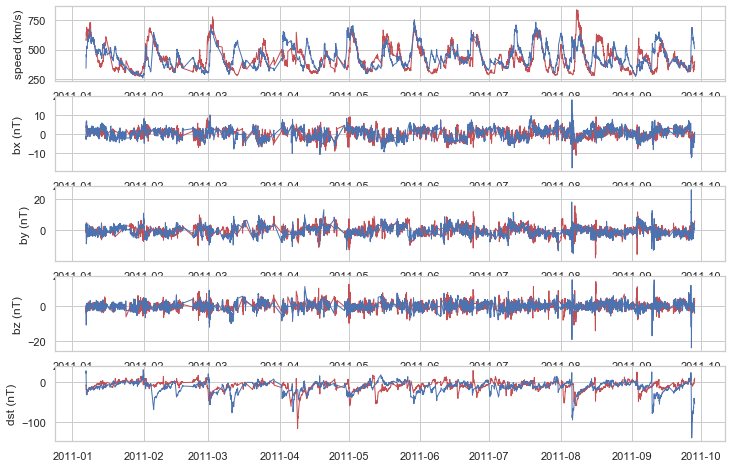

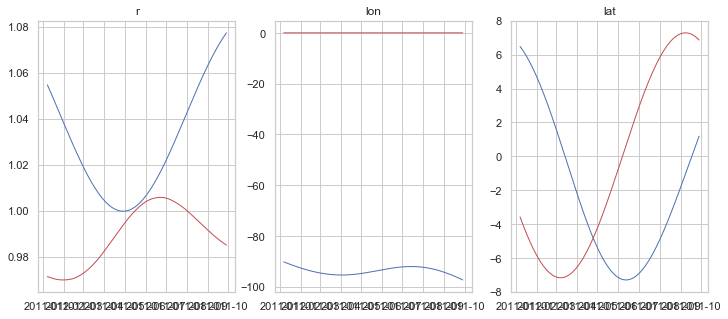

2011-02-06 04:00:00+00:00 2011-10-21 07:00:00+00:00
Data points inside -92.5 < angle < -99.5: 4050
speed -- corr:      0.43 -- offset: 0 hrs
speed -- corr_mean: 0.48 -- corr_std: 0.11
btot -- corr:      0.08 -- offset: -17 hrs
btot -- corr_mean: 0.10 -- corr_std: 0.10
bx -- corr:      0.36 -- offset: 0 hrs
bx -- corr_mean: 0.42 -- corr_std: 0.04
by -- corr:      0.27 -- offset: 5 hrs
by -- corr_mean: 0.38 -- corr_std: 0.06
bz -- corr:      0.11 -- offset: 14 hrs
bz -- corr_mean: 0.14 -- corr_std: 0.08


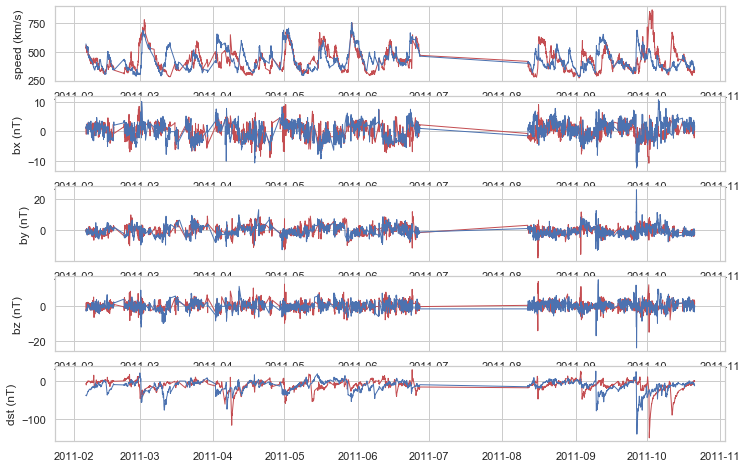

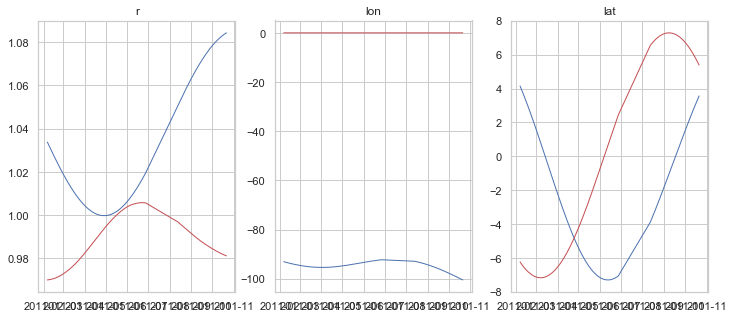

2011-09-19 16:00:00+00:00 2011-11-11 03:00:00+00:00
Data points inside -95.5 < angle < -102.5: 1024
speed -- corr:      0.36 -- offset: 0 hrs
speed -- corr_mean: 0.36 -- corr_std: 0.22
btot -- corr:      -0.15 -- offset: 53 hrs
btot -- corr_mean: -0.16 -- corr_std: 0.09
bx -- corr:      0.27 -- offset: 14 hrs
bx -- corr_mean: 0.31 -- corr_std: 0.12
by -- corr:      0.25 -- offset: 66 hrs
by -- corr_mean: 0.29 -- corr_std: 0.10
bz -- corr:      0.08 -- offset: 16 hrs
bz -- corr_mean: 0.15 -- corr_std: 0.02


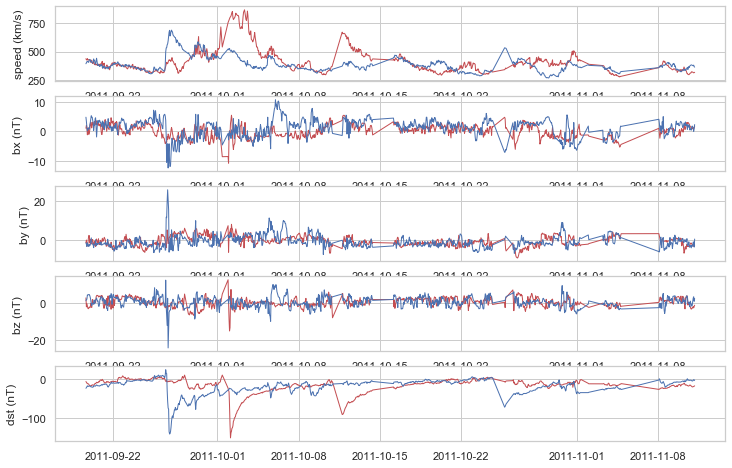

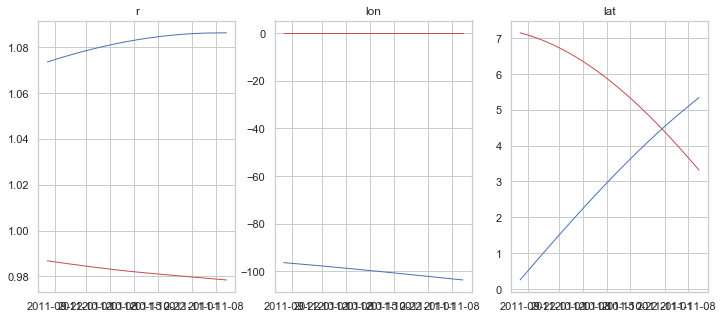

2011-10-14 03:00:00+00:00 2011-12-02 02:00:00+00:00
Data points inside -98.5 < angle < -105.5: 801
speed -- corr:      0.34 -- offset: 0 hrs
speed -- corr_mean: 0.33 -- corr_std: 0.03
btot -- corr:      0.00 -- offset: 18 hrs
btot -- corr_mean: 0.02 -- corr_std: 0.06
bx -- corr:      0.34 -- offset: 13 hrs
bx -- corr_mean: 0.34 -- corr_std: 0.10
by -- corr:      0.20 -- offset: -18 hrs
by -- corr_mean: 0.20 -- corr_std: 0.13
bz -- corr:      0.12 -- offset: 18 hrs
bz -- corr_mean: 0.19 -- corr_std: 0.02


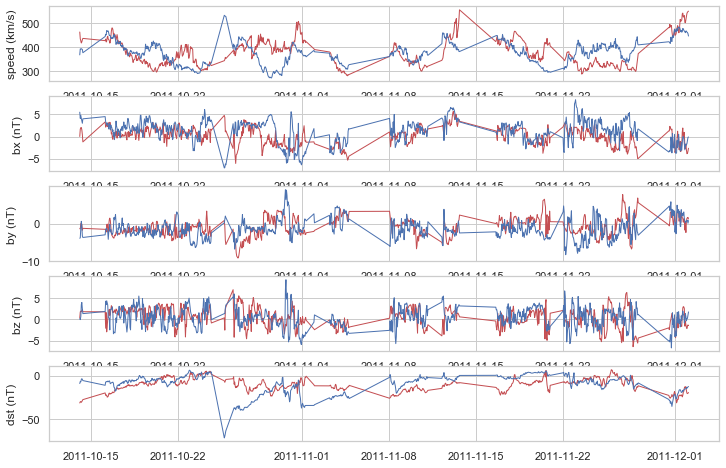

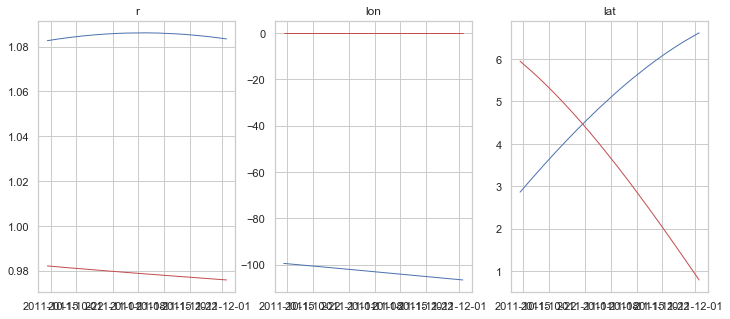

2011-11-04 08:00:00+00:00 2011-12-23 02:00:00+00:00
Data points inside -101.5 < angle < -108.5: 831
speed -- corr:      0.61 -- offset: 0 hrs
speed -- corr_mean: 0.61 -- corr_std: 0.18
btot -- corr:      0.27 -- offset: -14 hrs
btot -- corr_mean: 0.29 -- corr_std: 0.27
bx -- corr:      0.32 -- offset: -15 hrs
bx -- corr_mean: 0.35 -- corr_std: 0.23
by -- corr:      0.29 -- offset: -7 hrs
by -- corr_mean: 0.32 -- corr_std: 0.23
bz -- corr:      -0.02 -- offset: -75 hrs
bz -- corr_mean: -0.01 -- corr_std: 0.16


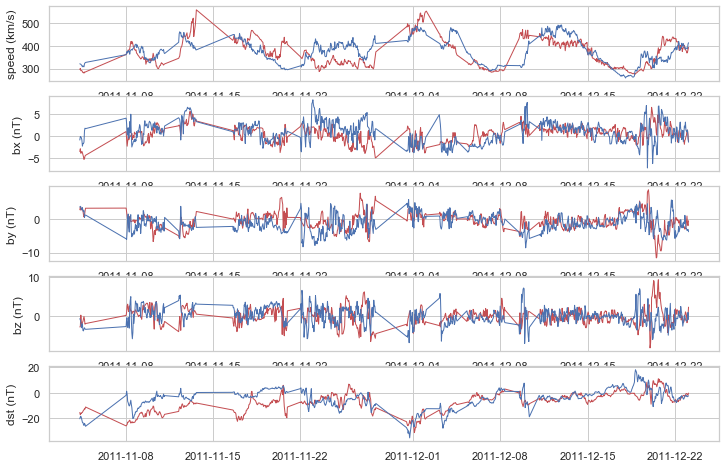

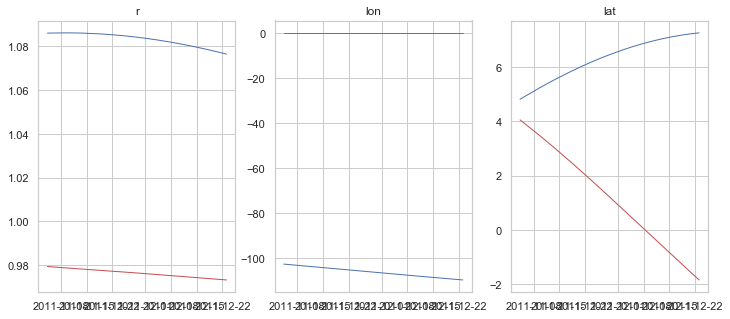

2011-11-25 00:00:00+00:00 2012-01-14 11:00:00+00:00
Data points inside -104.5 < angle < -111.5: 997
speed -- corr:      0.48 -- offset: 0 hrs
speed -- corr_mean: 0.49 -- corr_std: 0.21
btot -- corr:      0.28 -- offset: -12 hrs
btot -- corr_mean: 0.31 -- corr_std: 0.20
bx -- corr:      0.22 -- offset: -9 hrs
bx -- corr_mean: 0.25 -- corr_std: 0.20
by -- corr:      0.29 -- offset: -6 hrs
by -- corr_mean: 0.34 -- corr_std: 0.21
bz -- corr:      -0.12 -- offset: 44 hrs
bz -- corr_mean: -0.13 -- corr_std: 0.23


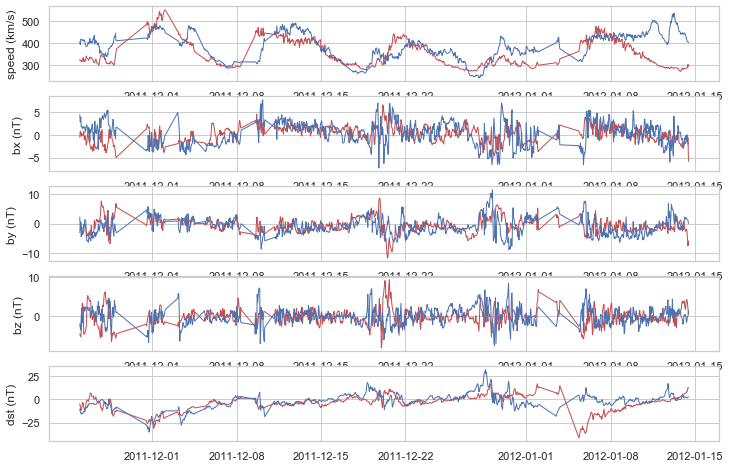

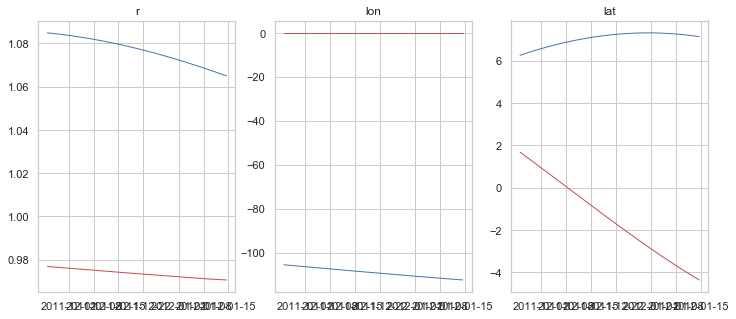

In [27]:
# LOOK AT VARIABLES ACROSS TIME
# Checking data between STEREO-B and OMNI
steptype = 'angle'
if steptype == 'time':
    step = 30*3
    min_time = np.round(stbh['time'][np.where(stbh_lons*180/np.pi < -0)[0][0]], 0)
    max_time = np.round(stbh['time'][np.where(stbh_lons*180/np.pi < -110)[0][0]], 0)
    teststeps = np.arange(min_time, max_time, step)
elif steptype == 'angle':
    lonstep = -3
    lonrange = 7
    teststeps = range(angle_bracket[0], angle_bracket[1], lonstep)

print('Time range covered for analysis in angle bracket [-0, -110]:')
print('start:', num2date(min_time))
print('end:  ', num2date(max_time))
print("")

dttime = [num2date(t).replace(tzinfo=None) for t in stbh['time']]
L1Pos = ps.get_l1_position(dttime, units=stbh.pos.h['Units'], refframe=stbh.pos.h['ReferenceFrame'])

cc_vals = {'lats': [], 'lons': [], 'speed': [], 'btot': [], 'bx': [], 'by': [], 'bz': []}
count = 0
plot_every_n = 1 # 4 to plot every fourth plot
for dtest in teststeps:
    if steptype == 'time':
        t_inds = np.where((stbh['time'] > (dtest)) & (stbh['time'] < dtest+step))
        t_inds_mean = np.where((stbh_mean['time'] > (dtest)) & (stbh_mean['time'] < dtest+step))
    elif steptype == 'angle':
        t_inds = np.where((stbh_lons*180/np.pi > (dtest-lonrange/2.)) & 
                          (stbh_lons*180/np.pi < (dtest+lonrange/2.)))
        print(num2date(stbh['time'][t_inds][0]), num2date(stbh['time'][t_inds][-1]))
        t_inds_mean = np.where((stbh_mean['time'] >= stbh['time'][t_inds][0]) & 
                               (stbh_mean['time'] < stbh['time'][t_inds][-1]))
    lats = stbh_lats[t_inds]*180./np.pi
    lons = stbh_lons[t_inds]*180./np.pi
    cc_vals['lats'].append(np.mean(lats))
    cc_vals['lons'].append(np.mean(lons))
    print('Data points inside {:.1f} < angle < {:.1f}: {}'.format(np.max(lons), np.min(lons), len(t_inds[0])))
    t = np.linspace(0.0, stbh['time'][t_inds][-1] - stbh['time'][t_inds][0], len(t_inds[0]), endpoint=False)
    dt = np.linspace(-t[-1], t[-1], 2*len(t_inds[0])-1)
    for varo in ['speed', 'btot', 'bx', 'by', 'bz']:
        cc_val = np.corrcoef(omni[varo][t_inds], stbh[varo][t_inds])[0][1]
        cc_vals[varo].append(cc_val)
        xcorr = scipy.signal.correlate(stbh[varo][t_inds], omni[varo][t_inds])
        hours_offset = 24.*dt[xcorr.argmax()]
        print("{} -- corr:      {:.2f} -- offset: {:.0f} hrs".format(varo, cc_val, hours_offset))
        corr_mean = np.corrcoef(stbh_mean[varo][t_inds_mean], omni_mean[varo][t_inds_mean])[0][1]
        corr_std = np.corrcoef(stbh_std[varo][t_inds_mean], omni_std[varo][t_inds_mean])[0][1]
        if varo+'_mean' in cc_vals.keys():
            cc_vals[varo+'_mean'].append(corr_mean)
        else:
            cc_vals[varo+'_mean'] = [corr_mean]
        if varo+'_std' in cc_vals.keys():
            cc_vals[varo+'_std'].append(corr_std)
        else:
            cc_vals[varo+'_std'] = [corr_std]
        print("{} -- corr_mean: {:.2f} -- corr_std: {:.2f}".format(varo, corr_mean, corr_std))
    
    if count%plot_every_n == 0:  # only print every fourth plot
        nfig += 1
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, num=nfig, figsize=(12,8))
        ax1.plot_date(stbh['time'][t_inds], stbh['speed'][t_inds], 'r-', lw=1)
        ax1.plot_date(omni['time'][t_inds], omni['speed'][t_inds], 'b-', lw=1)
        ax2.plot_date(stbh['time'][t_inds], stbh['bx'][t_inds], 'r-', lw=1)
        ax2.plot_date(omni['time'][t_inds], omni['bx'][t_inds], 'b-', lw=1)
        ax3.plot_date(stbh['time'][t_inds], stbh['by'][t_inds], 'r-', lw=1)
        ax3.plot_date(omni['time'][t_inds], omni['by'][t_inds], 'b-', lw=1)
        ax4.plot_date(stbh['time'][t_inds], stbh['bz'][t_inds], 'r-', lw=1)
        ax4.plot_date(omni['time'][t_inds], omni['bz'][t_inds], 'b-', lw=1)
        ax5.plot_date(stbh['time'][t_inds], stbh['dst'][t_inds], 'r-', lw=1)
        ax5.plot_date(omni['time'][t_inds], omni['ae'][t_inds], 'b-', lw=1)
        ax1.set_ylabel("speed (km/s)")
        ax2.set_ylabel("bx (nT)")
        ax3.set_ylabel("by (nT)")
        ax4.set_ylabel("bz (nT)")
        ax5.set_ylabel("dst (nT)")

        nfig +=1
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, num=nfig, figsize=(12,5))
        ax1.plot_date(stbh['time'][t_inds], stbh.pos['r'][t_inds], 'b-', lw=1)
        ax1.plot_date(omni['time'][t_inds], L1Pos['r'][t_inds], 'r-', lw=1)
        ax1.set_title('r')
        ax2.plot_date(stbh['time'][t_inds], stbh.pos['lon'][t_inds]*180/np.pi, 'b-', lw=1)
        ax2.plot_date(omni['time'][t_inds], L1Pos['lon'][t_inds]*180/np.pi, 'r-', lw=1)
        ax2.set_title('lon')
        ax3.plot_date(stbh['time'][t_inds], stbh.pos['lat'][t_inds]*180/np.pi, 'b-', lw=1)
        ax3.plot_date(omni['time'][t_inds], L1Pos['lat'][t_inds]*180/np.pi, 'r-', lw=1)
        ax3.set_title('lat')

        plt.show()
    count += 1

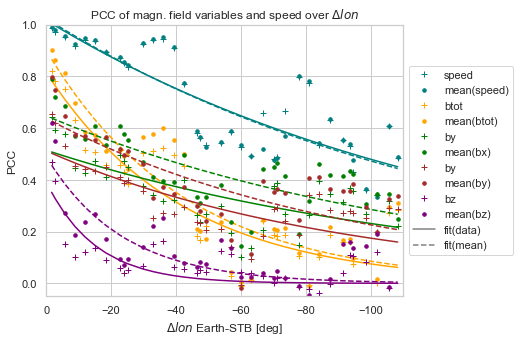

In [28]:
# Plot means over delta-lon
from scipy.optimize import curve_fit 
ms = '+'
ms_mean = '.'
msize = 7
def decaying_fit(x, a, e): 
    return a*np.exp(e*x)
x = np.array(cc_vals['lons'])

fig = plt.figure(figsize=(8,5))
#speed
param, param_cov = curve_fit(decaying_fit, x, cc_vals['speed']) 
btot_fit = decaying_fit(x, *param)
param, param_cov = curve_fit(decaying_fit, x, cc_vals['speed_mean']) 
btot_mean_fit = decaying_fit(x, *param)
plt.plot(x, cc_vals['speed'], ms, c=varcolors['speed'], label='speed')
plt.plot(x, btot_fit, '-', c=varcolors['speed'])
plt.plot(x, cc_vals['speed_mean'], ms_mean, c=varcolors['speed'], label='mean(speed)', ms=msize)#, mfc='none')
plt.plot(x, btot_mean_fit, '--', c=varcolors['speed'])
#btot
param, param_cov = curve_fit(decaying_fit, x, cc_vals['btot']) 
btot_fit = decaying_fit(x, *param)
param, param_cov = curve_fit(decaying_fit, x, cc_vals['btot_mean']) 
btot_mean_fit = decaying_fit(x, *param)
plt.plot(x, cc_vals['btot'], ms, c=varcolors['btot'], label='btot')
plt.plot(x, btot_fit, '-', c=varcolors['btot'])
plt.plot(x, cc_vals['btot_mean'], ms_mean, c=varcolors['btot'], label='mean(btot)', ms=msize)#, mfc='none')
plt.plot(x, btot_mean_fit, '--', c=varcolors['btot'])
#bx
param, param_cov = curve_fit(decaying_fit, x, cc_vals['bx']) 
bx_fit = decaying_fit(x, *param)
param, param_cov = curve_fit(decaying_fit, x, cc_vals['bx_mean']) 
bx_mean_fit = decaying_fit(x, *param)
plt.plot(x, cc_vals['bx'], ms, c=varcolors['bx'], label='by')
plt.plot(x, bx_fit, '-', c=varcolors['bx'])
plt.plot(x, cc_vals['bx_mean'], ms_mean, c=varcolors['bx'], label='mean(bx)', ms=msize)#, mfc='none')
plt.plot(x, bx_mean_fit, '--', c=varcolors['bx'])
#by
param, param_cov = curve_fit(decaying_fit, x, cc_vals['by']) 
by_fit = decaying_fit(x, *param)
param, param_cov = curve_fit(decaying_fit, x, cc_vals['by_mean']) 
by_mean_fit = decaying_fit(x, *param)
plt.plot(x, cc_vals['by'], ms, c=varcolors['by'], label='by')
plt.plot(x, by_fit, '-', c=varcolors['by'])
plt.plot(x, cc_vals['by_mean'], ms_mean, c=varcolors['by'], label='mean(by)', ms=msize)#, mfc='none')
plt.plot(x, by_mean_fit, '--', c=varcolors['by'])
#bz
param, param_cov = curve_fit(decaying_fit, x, cc_vals['bz']) 
bz_fit = decaying_fit(x, *param)
param, param_cov = curve_fit(decaying_fit, x, cc_vals['bz_mean']) 
bz_mean_fit = decaying_fit(x, *param)
plt.plot(x, cc_vals['bz'], ms, c=varcolors['bz'], label='bz')
plt.plot(x, bz_fit, '-', c=varcolors['bz'])
plt.plot(x, cc_vals['bz_mean'], ms_mean, c=varcolors['bz'], label='mean(bz)', ms=msize)#, mfc='none')
plt.plot(x, bz_mean_fit, '--', c=varcolors['bz'])

plt.plot([10,20], [-1,-2], '-', c='grey', label='fit(data)')
plt.plot([10,20], [-1,-2], '--', c='grey', label='fit(mean)')

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, fontsize=9)
#plt.legend(loc="upper right", fontsize=9)

plt.xlim((0,-110))
plt.ylim((-0.05, 1.0))
plt.title("PCC of magn. field variables and speed over $\Delta lon$")
plt.xlabel(r"$\Delta lon$ Earth-STB [deg]")
plt.ylabel("PCC")
plt.savefig("plots/vars_pcc.pdf")
plt.show()

### Dst accuracy depending on L5-L1 longitude angle diff

Notes:
- Errors from OMNI remain roughly the same over time ranges
- Errors from STEREO appear to increase with increasing distance from L1
- Besides increase, errors follow same trend as OMNI

In [29]:
#tstep = 30
#trange = 60
#min_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < -0)[0][0]], 0)
#max_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < -110)[0][0]], 0)
#testtimes = np.arange(min_time, max_time, step)

#dttime = [num2date(t).replace(tzinfo=None) for t in stbh['time']]
#L1Pos = ps.get_l1_position(dttime, units=stbh.pos.h['Units'], refframe=stbh.pos.h['ReferenceFrame'])

#stat_dicts = {'omni': [], 'stb': [], 'pers': [], 'angles': [], 'latdiffs': []}
#for dtest in testtimes:
#    t_inds = np.where((stbh['time'] > (dtest)) & (stbh['time'] < dtest+step))
#    lats = stbh.pos['lat'][t_inds]*180./np.pi
#    lons = stbh.pos['lon'][t_inds]*180./np.pi
#    stat_dicts['angles'].append(np.mean(lons))

lonstep = -1
lonrange = 4
testangles = range(angle_bracket[0], angle_bracket[1], lonstep)
diff_stds, diff_stds_omni = [], []
stat_dicts = {'omni': [], 'stb': [], 'pers': [], 'lons': [], 'latdiffs': [], 'stblat': [], 'l1lat': []}
for dtest in testangles:
    t_inds = np.where((stbh_lons*180/np.pi > (dtest-lonrange/2.)) & 
                      (stbh_lons*180/np.pi < (dtest+lonrange/2.)))
    stat_dicts['lons'].append(dtest)
    stat_dicts['latdiffs'].append(np.mean(stbh_lats[t_inds]*180./np.pi - L1Pos['lat'][t_inds]*180/np.pi))
    stat_dicts['stblat'].append(np.mean(stbh_lats[t_inds]*180./np.pi))
    stat_dicts['l1lat'].append(np.mean(L1Pos['lat'][t_inds]*180/np.pi))

    #print('Data points inside {} < angle < {}: {}'.format((dtest-lonrange/2.), 
    #                                                      (dtest+lonrange/2.), len(t_inds[0])))

    if len(t_inds[0]) != 0:
        stat_dict_omni = get_statistics(dst_temerinli_omni[t_inds], odst[t_inds], printtext=False)
        stat_dict = get_statistics(dst_temerinli[t_inds], odst[t_inds], printtext=False)
        stat_dict_pers = get_statistics(dst_temerinli_pers[t_inds], odst[t_inds], printtext=False)
    stat_dicts['omni'].append(stat_dict_omni)
    stat_dicts['stb'].append(stat_dict)
    stat_dicts['pers'].append(stat_dict_pers)
    #print('Dst diff mean (L1) +/- std: {:.1f} +/- {:.1f}'.format(stat_dict_omni['diff_mean'], 
    #                                                             stat_dict_omni['diff_std']))
    #print('Dst diff mean (L5) +/- std: {:.1f} +/- {:.1f}'.format(stat_dict['diff_mean'], 
    #                                                             stat_dict['diff_std']))
    diff_stds_omni.append(stat_dict_omni['diff_std'])
    diff_stds.append(stat_dict['diff_std'])

OMNI CC:   slope=0.0001, intercept=0.90, mean=0.88
STB  CC:   slope=0.0056, intercept=0.64, mean=0.35
PERS CC:   slope=0.0035, intercept=0.44, mean=0.24
----
OMNI MAE:  slope=-0.0022, intercept=3.66, mean=3.82
STB  MAE:  slope=-0.0360, intercept=5.64, mean=7.97
PERS MAE:  slope=-0.0310, intercept=7.05, mean=9.12
----
OMNI RMSE: slope=-0.0013, intercept=4.80, mean=4.88
STB  RMSE: slope=-0.0447, intercept=7.71, mean=11.03
PERS RMSE: slope=-0.0396, intercept=9.90, mean=12.59
----
OMNI ME:   slope=0.0217, intercept=0.95, mean=-0.09
STB  ME:   slope=0.0284, intercept=1.69, mean=-0.25
PERS ME:   slope=0.0040, intercept=-0.94, mean=-1.17


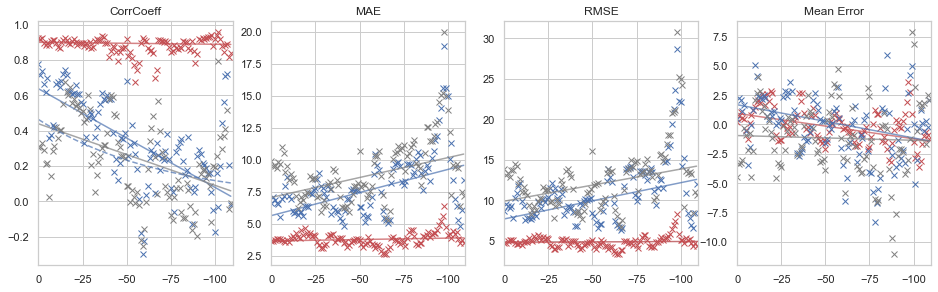

In [30]:
# Get arrays of metrics:
# ----------------------
# Longitude values
modnames = ['omni', 'stb', 'pers']
dlons = np.array(stat_dicts['lons'])
dlats = np.array(stat_dicts['latdiffs'])
ppmc, slope_cc, intercept_cc, mean_cc = {}, {}, {}, {}
mean, slope_me, intercept_me, mean_me = {}, {}, {}, {}
mae, slope_mae, intercept_mae, mean_mae = {}, {}, {}, {}
rmse, slope_rmse, intercept_rmse, mean_rmse = {}, {}, {}, {}
for modname in modnames:
    # Correlation between predicted and observed Dst
    ppmc[modname] = np.array([x['ppmc'] for x in stat_dicts[modname]])
    slope_cc[modname], intercept_cc[modname], lo_slope, up_slope = stats.theilslopes(ppmc[modname], dlons)
    # Mean of error between pred and obs
    mean[modname] = np.array([x['diff_mean'] for x in stat_dicts[modname]])
    slope_me[modname], intercept_me[modname], lo_slope, up_slope = stats.theilslopes(mean[modname], dlons)
    # Mean average error (MAE) between pred and obs
    mae[modname] = np.array([x['mae'] for x in stat_dicts[modname]])
    slope_mae[modname], intercept_mae[modname], lo_slope, up_slope = stats.theilslopes(mae[modname], dlons)
    # Root mean square error (RMSE) between pred and obs
    rmse[modname] = np.array([x['rmse'] for x in stat_dicts[modname]])
    slope_rmse[modname], intercept_rmse[modname], lo_slope, up_slope = stats.theilslopes(rmse[modname], dlons)

for modname in modnames:
    print("{:<4} CC:   slope={:.4f}, intercept={:.2f}, mean={:.2f}".format(modname.upper(), slope_cc[modname], 
                                                                           intercept_cc[modname], 
                                                                           np.mean(ppmc[modname])))
print("----")
for modname in modnames:
    print("{:<4} MAE:  slope={:.4f}, intercept={:.2f}, mean={:.2f}".format(modname.upper(), slope_mae[modname], 
                                                                           intercept_mae[modname],
                                                                           np.mean(mae[modname])))
print("----")
for modname in modnames:
    print("{:<4} RMSE: slope={:.4f}, intercept={:.2f}, mean={:.2f}".format(modname.upper(), slope_rmse[modname], 
                                                                           intercept_rmse[modname],
                                                                           np.mean(rmse[modname])))
print("----")
for modname in modnames:
    print("{:<4} ME:   slope={:.4f}, intercept={:.2f}, mean={:.2f}".format(modname.upper(), slope_me[modname], 
                                                                           intercept_me[modname],
                                                                           np.mean(mean[modname])))

# Test plot:
# ----------
nfig += 1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, num=nfig, figsize=(16, 4.5))
for modname in modnames:
    ax1.plot(dlons, ppmc[modname], 'x', c=modc[modname], label=modname.upper())
    ax1.plot(dlons, slope_cc[modname]*dlons+intercept_cc[modname], '-', c=modc[modname], alpha=0.7)
ax1.set_title("CorrCoeff")
ax1.set_xlim([angle_bracket[0], angle_bracket[1]])

for modname in modnames:
    ax2.plot(dlons, mae[modname], 'x', c=modc[modname], label=modname.upper())
    ax2.plot(dlons, slope_mae[modname]*dlons+intercept_mae[modname], '-', c=modc[modname], alpha=0.7)
ax2.set_title("MAE")
ax2.set_xlim([angle_bracket[0], angle_bracket[1]])

for modname in modnames:
    ax3.plot(dlons, rmse[modname], 'x', c=modc[modname], label=modname.upper())
    ax3.plot(dlons, slope_rmse[modname]*dlons+intercept_rmse[modname], '-', c=modc[modname], alpha=0.7)
ax3.set_title("RMSE")
ax3.set_xlim([angle_bracket[0], angle_bracket[1]])

for modname in modnames:
    ax4.plot(dlons, mean[modname], 'x', c=modc[modname], label=modname.upper())
    ax4.plot(dlons, slope_me[modname]*dlons+intercept_me[modname], '-', c=modc[modname], alpha=0.7)
ax4.set_title("Mean Error")
ax4.set_xlim([angle_bracket[0], angle_bracket[1]])

def decaying_fit(x, e, b): 
    return b*np.exp(e*x)
x = np.array(cc_vals['lons'])

param, param_cov = curve_fit(decaying_fit, dlons, ppmc[modname])
pcc_fit = decaying_fit(dlons, *param)
ax1.plot(dlons, pcc_fit, '--', c=modc['stb'], alpha=0.7)

plt.show()

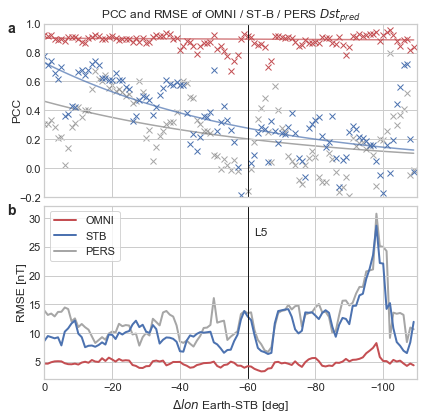

In [31]:
# Plot correlation values between variables:
nfig += 1
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, num=nfig, figsize=(figwidth, 4.5))
fig, (ax2, ax3) = plt.subplots(2, 1, num=nfig, figsize=(figwidth/2, 6), sharex=True)

# First plot: correlation of variables with increasing distance
#for varo, c, m in zip(['speed', 'btot', 'bx', 'by', 'bz'], 
#                      ['teal','orange','green','coral','purple'], ['o','v','s','^','p']):
#    ax1.plot(cc_vals_10['lons'], cc_vals_10[varo], color=c, ls='--', lw=0.5)
#    ax1.scatter(cc_vals_10['lons'], cc_vals_10[varo], color=c, label=varo, marker=m)
#    ax1.set_xlim([cc_vals_10['lons'][0]+0.5, cc_vals_10['lons'][-1]-0.5])

# Second plot: correlation of Dst(OMNI) and Dst(STB) with Kyoto-Dst
ax2.plot(dlons, ppmc['omni'], 'x', c=modc['omni'], label='OMNI', zorder=2)
ax2.plot(dlons, ppmc['stb'], 'x', c=modc['stb'], label='STB', zorder=1)
ax2.plot(dlons, ppmc['pers'], 'x', c=modc['pers'], alpha=alpha_pers, label='PERS', zorder=0)

# Line denoting position of L5:
ax2.axvline(-60, c='k', lw=1)
#ax2.annotate('L5', (-62, 0.68))
ax3.axvline(-60, c='k', lw=1)
ax3.annotate('L5', (-62, 27))

param, param_cov = curve_fit(decaying_fit, dlons, ppmc['stb']) 
stb_fit = decaying_fit(dlons, *param)
param, param_cov = curve_fit(decaying_fit, dlons, ppmc['pers']) 
pers_fit = decaying_fit(dlons, *param)

# Add linear functions:
ax2.plot(dlons, slope_cc['omni']*dlons+intercept_cc['omni'], '-', c=modc['omni'], alpha=0.7, zorder=2)
ax2.plot(dlons, stb_fit, '-', c=modc['stb'], alpha=0.7, zorder=1)
ax2.plot(dlons, pers_fit, '-', c=modc['pers'], alpha=alpha_pers, zorder=0)

# Third plot: mean average error and stddev of Dst(OMNI) and Dst(STB) with Kyoto-Dst
ax3.plot(dlons, rmse['omni'], c=modc['omni'], ls='-', lw=2, label='OMNI', zorder=2)
#ax3.fill_between(dlons, mean_omni-std_omni, mean_omni+std_omni,
#                 facecolor='r', alpha=0.5)
ax3.plot(dlons, rmse['stb'], c=modc['stb'], ls='-', lw=2, label='STB', zorder=1)
#ax3.fill_between(dlons, mean_stb-std_stb, mean_stb+std_stb,
#                 facecolor='b', alpha=0.5)
ax3.plot(dlons, rmse['pers'], c=modc['pers'], alpha=alpha_pers, ls='-', lw=2, label='PERS', zorder=0)
        
# Formatting:
ylabelpad = -3
ticklabelpad = -2.5
#ax1.set_title("PCC and RMSE of OMNI / ST-B / PERS $Dst_{pred}$")
#ax1.set_xlabel(r"$\Delta lon$ Earth-STB [deg]")
#ax1.set_ylabel("correlation coefficient", labelpad=ylabelpad)
#ax1.tick_params(pad=ticklabelpad)
#ax1.legend()
ax2.set_title("PCC and RMSE of OMNI / ST-B / PERS $Dst_{pred}$")
#ax2.set_xlabel(r"$\Delta lon$ Earth-STB [deg]")
ax2.set_ylabel("PCC", labelpad=ylabelpad)
ax2.tick_params(pad=ticklabelpad)
ax2.set_xlim([angle_bracket[0], angle_bracket[1]])
ax2.set_ylim((-0.2, 1.))
#ax2.legend()
#ax3.set_title("RMSE between pred. $Dst$ and Kyoto $Dst$")
ax3.set_xlabel(r"$\Delta lon$ Earth-STB [deg]")
ax3.set_ylabel("RMSE [nT]", labelpad=ylabelpad+5)
ax3.tick_params(pad=ticklabelpad)
ax3.set_xlim([angle_bracket[0], angle_bracket[1]])
ax3.legend(loc='upper left')

for ax, ann in zip([ax2, ax3], ['a', 'b']):
    ax.text(-0.1, 0.95, ann, transform=ax.transAxes, fontsize=14, weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("plots/corr_over_lon.pdf")
plt.show()

### Analysis of values according to Carrington rotation

Calculate PCC, RMSE, MAE, etc. according to Carrington rotation rather than delta-lon.

STEREO-B reached L5 at 2009-10-26 00:00:00+00:00
Number of Carrinton Rotations: 66
L5 reached by STEREO-B at: 2090.0


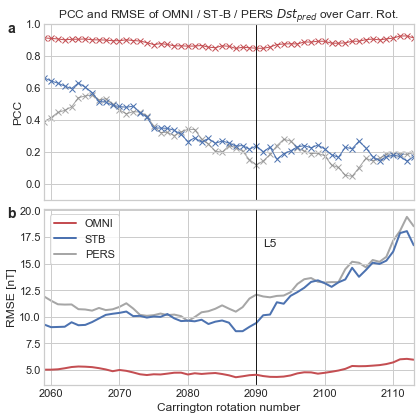

In [32]:
date_L5 = num2date(np.round(stbh['time'][np.where(stbh_lons*180/np.pi < -60)[0][0]], 0))
print("STEREO-B reached L5 at {}".format(date_L5))

carr_rot = np.loadtxt("data/CarringtonRotNums.txt", skiprows=1)
n_crot = np.array(carr_rot[:,0])
t_crot = np.array([(datetime(int(t-t%1),1,1) + timedelta(days=t%1*365.25)) for t in carr_rot[:,4]])
cut_inds = np.where(np.logical_and(t_crot >= num2date(omni['time'][0]-30).replace(tzinfo=None),
                                   t_crot < num2date(omni['time'][-1]).replace(tzinfo=None)))
n_crot_cut = n_crot[cut_inds]
t_crot_cut = t_crot[cut_inds]
n_crot_L5 = n_crot_cut[np.where(t_crot_cut > date_L5.replace(tzinfo=None))[0][0]]
print("Number of Carrinton Rotations:", len(n_crot_cut))
print("L5 reached by STEREO-B at: {}".format(n_crot_L5))

rot_nums, rot_rmse, rot_pcc = [], {'omni': [], 'stb': [], 'pers': []}, {'omni': [], 'stb': [], 'pers': []}
stat_dict = {'omni': [], 'stb': [], 'pers': []}
for inum, num in enumerate(n_crot_cut[:-1]):
    start = date2num(t_crot_cut[inum])
    end = date2num(t_crot_cut[inum+1])
    t_inds = np.where(np.logical_and(omni['time'] >= start, omni['time'] < end))[0]
    
    stat_dict['omni'] = get_statistics(dst_temerinli_omni[t_inds], odst[t_inds], printtext=False)
    stat_dict['stb'] = get_statistics(dst_temerinli[t_inds], odst[t_inds], printtext=False)
    stat_dict['pers'] = get_statistics(dst_temerinli_pers[t_inds], odst[t_inds], printtext=False)
    rot_nums.append(num)
    for mod in modnames:
        rot_rmse[mod].append(stat_dict[mod]['rmse'])
        rot_pcc[mod].append(stat_dict[mod]['ppmc'])
        
window = 11
rot_nums_new, rot_rmse_win = [], {'omni': [], 'stb': [], 'pers': []}
rot_pcc_win = {'omni': [], 'stb': [], 'pers': []}
for i in range(int(window/2), len(rot_nums)-int(window/2)):
    rot_nums_new.append(rot_nums[i])
    for mod in modnames:
        rot_rmse_win[mod].append(np.mean(rot_rmse[mod][i-int(window/2):i+int(window/2)]))
        rot_pcc_win[mod].append(np.mean(rot_pcc[mod][i-int(window/2):i+int(window/2)]))
        
nfig += 1
fig, (ax1, ax2) = plt.subplots(2, 1, num=nfig, figsize=(figwidth/2, 6), sharex=True)

# First plot: mean average error and stddev of Dst(OMNI) and Dst(STB) with Kyoto-Dst
ax1.plot(rot_nums_new, rot_pcc_win['omni'], 'x', c=modc['omni'], lw=2, label='OMNI', zorder=2)
ax1.plot(rot_nums_new, rot_pcc_win['omni'], '-', c=modc['omni'], lw=1, zorder=2)
ax1.plot(rot_nums_new, rot_pcc_win['stb'], 'x', c=modc['stb'], lw=2, label='STB', zorder=1)
ax1.plot(rot_nums_new, rot_pcc_win['stb'], '-', c=modc['stb'], lw=1, zorder=1)
ax1.plot(rot_nums_new, rot_pcc_win['pers'], 'x', c=modc['pers'], alpha=alpha_pers, lw=2, label='PERS', zorder=0)
ax1.plot(rot_nums_new, rot_pcc_win['pers'], '-', c=modc['pers'], alpha=alpha_pers, lw=1, zorder=0)

# Line denoting position of L5:
ax1.axvline(2090, c='k', lw=1)
ax2.axvline(2090, c='k', lw=1)
ax2.annotate('L5', (2091, 16.6))

# Add linear functions:
#ax1.plot(dlons, slope_cc['omni']*dlons+intercept_cc['omni'], '-', c=modc['omni'], alpha=0.7, zorder=2)
#ax1.plot(dlons, slope_cc['stb']*dlons+intercept_cc['stb'], '-', c=modc['stb'], alpha=0.7, zorder=1)
#ax1.plot(dlons, slope_cc['pers']*dlons+intercept_cc['pers'], '-', c=modc['pers'], alpha=alpha_pers, zorder=0)

# Second plot: mean average error and stddev of Dst(OMNI) and Dst(STB) with Kyoto-Dst
ax2.plot(rot_nums_new, rot_rmse_win['omni'], c=modc['omni'], ls='-', lw=2, label='OMNI', zorder=2)
ax2.plot(rot_nums_new, rot_rmse_win['stb'], c=modc['stb'], ls='-', lw=2, label='STB', zorder=1)
ax2.plot(rot_nums_new, rot_rmse_win['pers'], c=modc['pers'], alpha=alpha_pers, ls='-', lw=2, label='PERS', zorder=0)
        
# Formatting:
ylabelpad = 2
ticklabelpad = -2.5
ax1.set_title("PCC and RMSE of OMNI / ST-B / PERS $Dst_{pred}$ over Carr. Rot.")
ax1.set_ylabel("PCC", labelpad=ylabelpad)
ax1.tick_params(pad=ticklabelpad)
ax1.set_xlim([rot_nums_new[0], rot_nums_new[-1]])
ax1.set_ylim((-0.1, 1.))
ax2.set_xlabel("Carrington rotation number")
ax2.set_ylabel("RMSE [nT]", labelpad=ylabelpad)
ax2.tick_params(pad=ticklabelpad)
#ax2.set_xlim([angle_bracket[0], angle_bracket[1]])
ax2.legend(loc='upper left')

for ax, ann in zip([ax1, ax2], ['a', 'b']):
    ax.text(-0.1, 0.95, ann, transform=ax.transAxes, fontsize=14, weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("plots/corr_over_crot.pdf")
plt.show()

### Dst accuracy depending on latitude diff

If we assume the overall trend in correlation is purely a result of longitudinal difference, we can subtract this while plotting against latitude to see the effect latitude difference has.

Correlation coefficient (corrected CC(Dst) with diff in lat.)  = 0.05
Correlation coefficient (corrected RMSE(Dst) with diff in lat.) = -0.34
Correlation coefficient (corrected MeanError(Dst) with diff in lat.) = 0.13
Correlation coefficient (corrected MAE(Dst) with diff in lat.) = -0.34


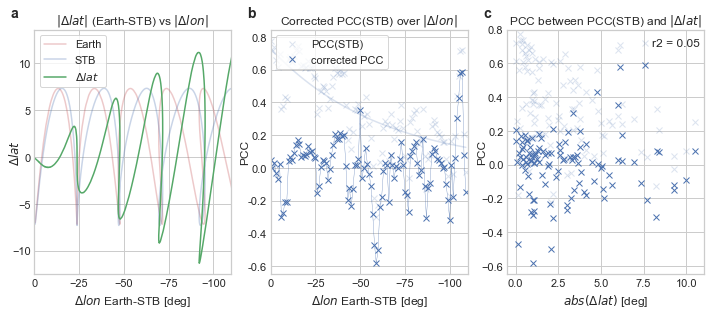

In [33]:
dlats = np.abs(np.array(stat_dicts['latdiffs']))
main_slope = 'stb'
minus_slope = 'omni'
limit = 110
cc_val_lat_cc = np.corrcoef(ppmc['stb'][:limit] - stb_fit[:limit] - slope_cc[minus_slope]*dlons, 
                            dlats[:limit])[0][1]
print("Correlation coefficient (corrected CC(Dst) with diff in lat.)  = {:.2f}".format(cc_val_lat_cc))
cc_val_lat_rmse = np.corrcoef(rmse['stb'][:limit] - slope_rmse[main_slope]*dlons[:limit],# - slope_rmse[minus_slope]*dlons, 
                              dlats[:limit])[0][1]
print("Correlation coefficient (corrected RMSE(Dst) with diff in lat.) = {:.2f}".format(cc_val_lat_rmse))
cc_val_lat_me = np.corrcoef(mean['stb'][:limit] - slope_me[main_slope]*dlons[:limit],# - slope_me[minus_slope]*dlons, 
                            dlats[:limit])[0][1]
print("Correlation coefficient (corrected MeanError(Dst) with diff in lat.) = {:.2f}".format(cc_val_lat_me))
cc_val_lat_mae = np.corrcoef(mae['stb'][:limit] - slope_mae[main_slope]*dlons[:limit],# - slope_mae[minus_slope]*dlons, 
                             dlats[:limit])[0][1]
print("Correlation coefficient (corrected MAE(Dst) with diff in lat.) = {:.2f}".format(cc_val_lat_mae))

plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(figwidth,4.5))
ax1.plot(stbh_lons*180/np.pi, L1Pos['lat']*180/np.pi, '-', c=modc['omni'], alpha=0.3, label="Earth")
ax1.plot(stbh_lons*180/np.pi, stbh_lats*180/np.pi, c=modc['stb'], alpha=0.3, label='STB')
ax1.plot(stbh_lons*180/np.pi, stbh_lats*180/np.pi - L1Pos['lat']*180/np.pi, 'g-', label="$\Delta lat$")

metric = ppmc
slope, intercept = slope_cc, intercept_cc
cc_val = cc_val_lat_cc
ax2.plot(dlons, metric['stb'], 'bx', label='PCC(STB)', alpha=0.2)
ax2.plot(dlons, metric['stb'] - stb_fit, 'bx', label='corrected PCC')
ax2.plot(dlons, metric['stb'] - stb_fit, 'b-', lw=0.3)
ax2.plot(dlons, stb_fit, 'b-', alpha=0.2)
ax3.plot(dlats, metric['stb'] - stb_fit, 'bx')
ax3.plot(dlats, metric['stb'], 'bx', alpha=0.2)

ylabelpad = 0
ticklabelpad = -2.5
xlims = (-0, -110)
ax1.set_xlim(xlims)
ax1.legend(loc='upper left')
ax1.set_xlabel(r"$\Delta lon$ Earth-STB [deg]")
ax1.set_ylabel("$\Delta lat$", labelpad=ylabelpad-9)
ax1.set_title("$|\Delta lat|$ (Earth-STB) vs $|\Delta lon|$")
ax1.tick_params(pad=ticklabelpad)
ax2.set_xlim(xlims)
ax2.legend(loc='upper left')
ax2.set_title("Corrected PCC(STB) over $|\Delta lon|$")
ax2.set_xlabel(r"$\Delta lon$ Earth-STB [deg]")
ax2.set_ylabel("PCC", labelpad=ylabelpad-2)
ax2.tick_params(pad=ticklabelpad)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))
ax3.annotate('r2 = {:.2f}'.format(cc_val), (8, 0.7))
ax3.set_xlabel("$abs(\Delta lat)$ [deg]")
ax3.set_ylabel("PCC", labelpad=ylabelpad+1)
ax3.set_title("PCC between PCC(STB) and $|\Delta lat|$")
ax3.tick_params(pad=ticklabelpad)
ax3.yaxis.set_label_coords(-0.1, 0.5)
ax3.set_ylim((-0.65,0.8))

for ax, ann in zip([ax1, ax2, ax3], ['a', 'b', 'c']):
    ax.text(-0.12, 1.05, ann, transform=ax.transAxes, fontsize=14, weight='bold')

plt.subplots_adjust(wspace=0.2)
#plt.tight_layout()
plt.savefig('plots/corr_over_lat.pdf')
plt.show()

### Event-based analysis with 12-hour windows

Calculate true/false event count for values of Dst below threshold (ideally -50 nT) within a time window, in this case 12 hours. Use overlapping windows of 12 hours at 6 hour resolution.

Corr. coeff. Dst(Kyoto) vs. Dst(OMNI) = 0.93
Corr. coeff. Dst(Kyoto) vs. Dst(ST-B) = 0.43
Corr. coeff. Dst(Kyoto) vs. Dst(PERS) = 0.33


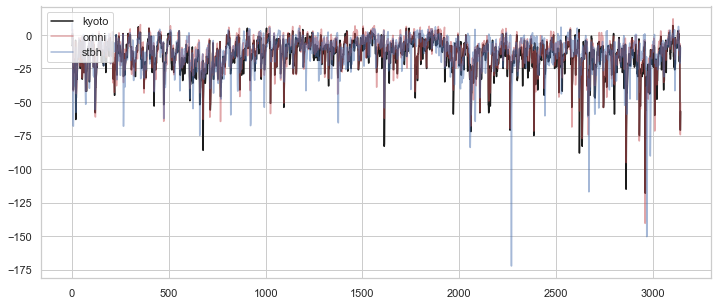

In [34]:
event_dst, event_time = {}, {}
for src, dstdata in zip(['kyoto', 'omni', 'stbh', 'pers'], 
                        [odst, dst_temerinli_omni, dst_temerinli, dst_temerinli_pers]):
    event_dst[src], event_time[src] = [], []
    for i in np.arange(event_window, len(dstdata)-event_window, event_window):
        #event_dst[src].append(len(np.where(dstdata[i-event_window:i+event_window] < event_threshold)[0]))
        event_dst[src].append(np.min(dstdata[i-event_window:i+event_window]))
        event_time[src].append(omni['time'][i])
        
cc_event_omni = np.corrcoef(event_dst['kyoto'], event_dst['omni'])[0][1]
cc_event_stbh = np.corrcoef(event_dst['kyoto'], event_dst['stbh'])[0][1]
cc_event_pers = np.corrcoef(event_dst['kyoto'], event_dst['pers'])[0][1]
print("Corr. coeff. Dst(Kyoto) vs. Dst(OMNI) = {:.2f}".format(cc_event_omni))
print("Corr. coeff. Dst(Kyoto) vs. Dst(ST-B) = {:.2f}".format(cc_event_stbh))
print("Corr. coeff. Dst(Kyoto) vs. Dst(PERS) = {:.2f}".format(cc_event_pers))

nfig += 1
fig = plt.figure(figsize=(figwidth,5))
plt.plot(event_dst['kyoto'], 'k-', label='kyoto')
plt.plot(event_dst['omni'], 'r-', alpha=0.5, label='omni')
plt.plot(event_dst['stbh'], 'b-', alpha=0.5, label='stbh')
plt.legend(loc='upper left')
plt.show()

event_dst['kyoto'] = np.array(event_dst['kyoto'])
event_dst['kyoto'][event_dst['kyoto'] > 1] = 1
event_dst['omni'] = np.array(event_dst['omni'])
event_dst['omni'][event_dst['omni'] > 1] = 1
event_dst['stbh'] = np.array(event_dst['stbh'])
event_dst['stbh'][event_dst['stbh'] > 1] = 1
event_dst['pers'] = np.array(event_dst['pers'])
event_dst['pers'][event_dst['pers'] > 1] = 1

# Save data to file:
savearray = np.vstack((range(0,len(event_dst['kyoto'])), event_dst['kyoto'], event_dst['omni'], 
                       event_dst['stbh'], event_dst['pers'])).T
fileheader = "time dst_kyoto dst_l1 dst_stb dst_pers"
np.savetxt("results/dst_data_24h.txt", savearray, fmt="%.5f", header=fileheader)

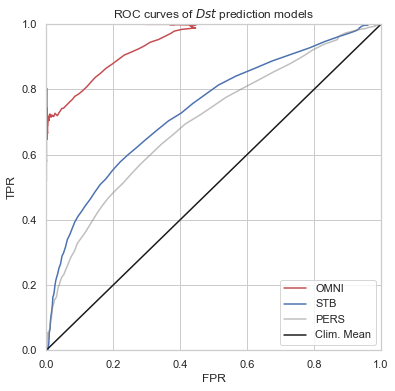

In [35]:
ROC_omni = np.loadtxt("osea_results/ROC_FPR_TPR_l1.txt")
ROC_stb = np.loadtxt("osea_results/ROC_FPR_TPR_stb.txt")
ROC_pers = np.loadtxt("osea_results/ROC_FPR_TPR_persistence.txt")
ROC_baseline = np.loadtxt("osea_results/ROC_FPR_TPR_baseline.txt")

fig = plt.figure(figsize=(figwidth/2, figwidth/2))
plt.plot(ROC_omni[:,0], ROC_omni[:,1], 'r-', label="OMNI")
plt.plot(ROC_stb[:,0], ROC_stb[:,1], 'b-', label="STB")
plt.plot(ROC_pers[:,0], ROC_pers[:,1], '-', c='grey', alpha=0.5, label="PERS")
plt.plot(ROC_baseline[:,0], ROC_baseline[:,1], 'k-', label="Clim. Mean")
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("ROC curves of $Dst$ prediction models")
plt.savefig("plots/roc_curves.pdf")
plt.show()

## DATA ANALYSIS (REDUCED RANGE)

Reducing range of angles from [0, -110] to [-50, -70].

Do some basic statistics then save data to file for event-based analysis.

In [36]:
angle_bracket_reduced = [-50, -70]
min_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < angle_bracket_reduced[0])[0][0]], 0)
max_time = np.round(stbh['time'][np.where(stbh.pos['lon']*180/np.pi < angle_bracket_reduced[1])[0][0]], 0)
print('Time range covered for analysis in angle bracket {}:'.format(angle_bracket_reduced))
print('start:', num2date(min_time))
print('end:  ', num2date(max_time))

# Cut data
stbh_red = copy.deepcopy(stbh)
stbh_red = stbh_red.cut(starttime=num2date(min_time), endtime=num2date(max_time))
omni_red = copy.deepcopy(omni)
omni_red = omni_red.cut(starttime=num2date(min_time), endtime=num2date(max_time))
pers_red = copy.deepcopy(pers)
pers_red = pers_red.cut(starttime=num2date(min_time), endtime=num2date(max_time))

Time range covered for analysis in angle bracket [-50, -70]:
start: 2009-08-02 00:00:00+00:00
end:   2010-01-31 00:00:00+00:00


In [37]:
# Get model Dst
dst_temerinli_omni_red = omni_red['ae']
dst_temerinli_pers_red = pers_red['dst']
dst_temerinli_red = stbh_red['dst']
# Actual Dst for interval
odst_red = omni_red['dst']

print("Mean, Min and Max:")
for ndata, data in zip(['Kyoto', 'OMNI', 'STB', 'PERS'],[odst_red, dst_temerinli_omni_red, 
                                                         dst_temerinli_red, dst_temerinli_pers_red]):
    print("{}: {:.2f} -- {:.2f} -- {:.2f}".format(ndata, np.nanmean(data), np.nanmin(data), np.nanmax(data)))

Mean, Min and Max:
Kyoto: -2.01 -- -47.00 -- 27.00
OMNI: -1.13 -- -42.34 -- 24.90
STB: -1.45 -- -40.67 -- 16.97
PERS: -0.83 -- -62.81 -- 24.17


In [38]:
# Get statistics
sd_omni_red = get_statistics(dst_temerinli_omni_red, odst_red, source='L1')
sd_stb_red = get_statistics(dst_temerinli_red, odst_red, source='STEREO-B')
sd_pers_red = get_statistics(dst_temerinli_pers_red, odst_red, source='PERSISTENCE MODEL')

DATA FROM L1
------------
Dst diff mean +/- std: -0.89 +/- 4.38

Dst obs  mean +/- std: -2.01 +/- 8.00
Dst pred mean +/- std: -1.13 +/- 7.62
Dst obs  min / max: -47.00 / 27.00
Dst pred min / max: -42.34 / 24.90

Pearson correlation: 0.85 
Cross-correlation:   0.0 hours
Mean absolute error: 3.38 nT
RMSE:                4.38 nT

DATA FROM STEREO-B
------------------
Dst diff mean +/- std: -0.56 +/- 8.89

Dst obs  mean +/- std: -2.01 +/- 8.00
Dst pred mean +/- std: -1.45 +/- 6.29
Dst obs  min / max: -47.00 / 27.00
Dst pred min / max: -40.67 / 16.97

Pearson correlation: 0.25 
Cross-correlation:   11.5 hours
Mean absolute error: 6.63 nT
RMSE:                8.89 nT

DATA FROM PERSISTENCE MODEL
---------------------------
Dst diff mean +/- std: -1.19 +/- 10.90

Dst obs  mean +/- std: -2.01 +/- 8.00
Dst pred mean +/- std: -0.83 +/- 8.36
Dst obs  min / max: -47.00 / 27.00
Dst pred min / max: -62.81 / 24.17

Pearson correlation: 0.12 
Cross-correlation:   -6251.1 hours
Mean absolute error: 8.0

In [39]:
# Save data to file:
savearray = np.vstack((omni_red['time'], odst_red, dst_temerinli_omni_red, 
                       dst_temerinli_red, dst_temerinli_pers_red,
                       omni_red['speed'], stbh_red['speed'], pers_red['speed'])).T
fileheader = "time dst_kyoto dst_l1 dst_stb dst_pers v_l1 v_stb v_pers"
np.savetxt("results/dst_data_red.txt", savearray, fmt="%.5f", header=fileheader)

## Offset in Dst as a function of offset in B

Plots the offset in Dst as a function of linear offset in magnetic field measurements.

In [40]:
offset_vars = ['bx', 'by', 'bz', 'btot']
offset_vals = [-1.0, -0.7, -0.5, -0.3, -0.1, 0., 0.1, 0.3, 0.5, 0.7, 1.0]
offset_results_mean = np.zeros((len(offset_vars), len(offset_vals)))
offset_results_min = np.zeros((len(offset_vars), len(offset_vals)))

omni = ps.get_omni_data(starttime=datetime(2007,1,1), endtime=datetime(2009,1,1), download=True)
omni = omni.interp_nans()

for ivar, var in enumerate(offset_vars):
    for ival, val in enumerate(offset_vals):
        print("Adding {} to {}".format(val, var))
        mag_offset = copy.deepcopy(omni)
        if var == 'btot':
            mag_offset[var] = np.sqrt(mag_offset['bx']**2. + mag_offset['by']**2. + mag_offset['bz']**2.)
            mag_offset[var] += val
        else:
            mag_offset[var] += val
            mag_offset['btot'] = np.sqrt(mag_offset['bx']**2. + mag_offset['by']**2. + mag_offset['bz']**2.)
        
        # Make dst predictions:
        dst_temerinli = mag_offset.make_dst_prediction()['dst']
        with open('dst_pred_model_final.pickle', 'rb') as f:
            model = pickle.load(f)
        dstdiff_pred = mag_offset.make_dst_prediction_from_model(model)['dst']
        dst_temerinli += dstdiff_pred
        
        offset_results_mean[ivar, ival] = np.mean(dst_temerinli)
        offset_results_min[ivar, ival] = np.min(dst_temerinli)
        #print('var\t', '\t'.join([str(x) for x in offset_vals]))
        #for ivar2, r in enumerate(offset_results_mean):
        #    print(offset_vars[ivar2]+'\t', '\t'.join(['{:.2f}'.format(x) for x in r]))
        #print()

null_offset_mean = offset_results_mean[0,offset_vals.index(0.0)]
offset_diffmean = offset_results_mean - null_offset_mean
null_offset_min = offset_results_min[0,offset_vals.index(0.0)]
offset_diffmin = offset_results_min - null_offset_min
print('var\t', '\t'.join([str(x) for x in offset_vals])) 
print("MEANS:")
for ivar2, r in enumerate(offset_diffmean): 
    print(offset_vars[ivar2]+'\t', '\t'.join(['{:.2f}'.format(x) for x in r])) 
print()
print("MINIMA:")
for ivar2, r in enumerate(offset_diffmin): 
    print(offset_vars[ivar2]+'\t', '\t'.join(['{:.2f}'.format(x) for x in r])) 
print()

Adding -1.0 to bx
Adding -0.7 to bx
Adding -0.5 to bx
Adding -0.3 to bx
Adding -0.1 to bx
Adding 0.0 to bx
Adding 0.1 to bx
Adding 0.3 to bx
Adding 0.5 to bx
Adding 0.7 to bx
Adding 1.0 to bx
Adding -1.0 to by
Adding -0.7 to by
Adding -0.5 to by
Adding -0.3 to by
Adding -0.1 to by
Adding 0.0 to by
Adding 0.1 to by
Adding 0.3 to by
Adding 0.5 to by
Adding 0.7 to by
Adding 1.0 to by
Adding -1.0 to bz
Adding -0.7 to bz
Adding -0.5 to bz
Adding -0.3 to bz
Adding -0.1 to bz
Adding 0.0 to bz
Adding 0.1 to bz
Adding 0.3 to bz
Adding 0.5 to bz
Adding 0.7 to bz
Adding 1.0 to bz
Adding -1.0 to btot
Adding -0.7 to btot
Adding -0.5 to btot
Adding -0.3 to btot
Adding -0.1 to btot
Adding 0.0 to btot
Adding 0.1 to btot
Adding 0.3 to btot
Adding 0.5 to btot
Adding 0.7 to btot
Adding 1.0 to btot
var	 -1.0	-0.7	-0.5	-0.3	-0.1	0.0	0.1	0.3	0.5	0.7	1.0
MEANS:
bx	 -0.00	-0.01	-0.01	-0.01	-0.00	0.00	0.00	0.01	0.02	0.03	0.06
by	 -0.11	-0.05	-0.02	-0.01	0.00	0.00	-0.00	-0.02	-0.04	-0.07	-0.14
bz	 -6.22	-4.27	-

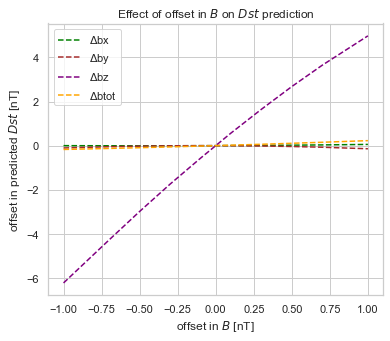

In [41]:
fig = plt.figure(figsize=figsize_half)
for ivar, var in enumerate(offset_vars[:4]):
    plt.plot(offset_vals, offset_diffmean[ivar], '--', c=varcolors[var], label=r'$\Delta$'+var)
plt.xlabel(r"offset in $B$ [nT]")
plt.ylabel(r"offset in predicted $Dst$ [nT]")
plt.title(r"Effect of offset in $B$ on $Dst$ prediction")
plt.legend()
plt.savefig("plots/dst_offset.pdf")
plt.show()